In [ ]:
#@title ##### License { display-mode: "form" }
# Copyright 2019 DeepMind Technologies Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# OpenSpiel

* This Colab gets you started with installing OpenSpiel and its dependencies.
* OpenSpiel is a framework for reinforcement learning in games.
* The instructions are adapted from [here](https://github.com/deepmind/open_spiel/blob/master/docs/install.md).

## Install

Install OpenSpiel via pip:


In [ ]:
!pip install --upgrade open_spiel

# It's play time!

In [1]:
####

Config: {'n_actions': 25, 'n_games': 3, 'T': 240000, 'eta': 0.1, 'L': 5, 'alpha_b': 1.0, 'alpha_s': 5.0, 'rho': 1.0, 'Kf': 5, 'K_win': 10, 'D_drop': 5, 'cautious_alpha': 4.0, 'cautious_beta': 70.0, 'cautious_newton_iters': 8, 'cautious_newton_tol': 1e-12, 'seed': 1, 'print_every': 500, 'plot_every': 100}

=== Game 1/3 (random 25x25) ===
[progress] t=     1  OMWU: ex=3.102e-01  OMWU-L(L=5): ex=2.887e-01  OMWU-EO(L=5): ex=2.887e-01  OMWU-EOO(L=5): ex=2.887e-01  OMWU-DECAY(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=2.887e-01  OMWU-DECAY-Gt(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=3.171e-01  OMWU-KD(K=10,D=5): ex=3.102e-01  KOMWU-Cautious(α=4.0,β=70.0): ex=3.102e-01
[progress] t=   500  OMWU: ex=1.570e-01  OMWU-L(L=5): ex=6.308e-02  OMWU-EO(L=5): ex=9.809e-02  OMWU-EOO(L=5): ex=6.911e-02  OMWU-DECAY(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=5.516e-02  OMWU-DECAY-Gt(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=5.241e-01  OMWU-KD(K=10,D=5): ex=1.087e-01  KOMWU-Cautious(α=4.0,β=70.0): ex=1.570e-01
[progress] t=  1000  OMWU: ex=1.534e-01  OMWU

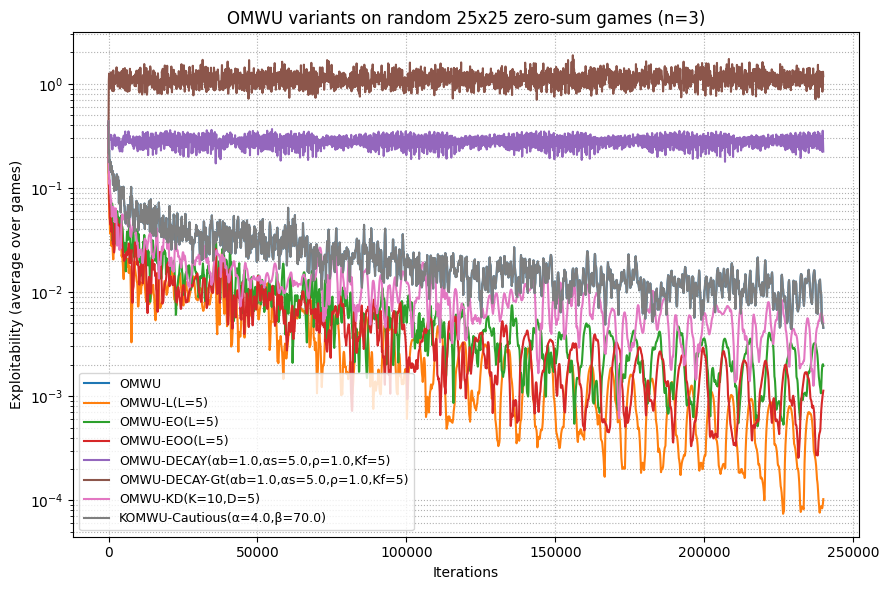

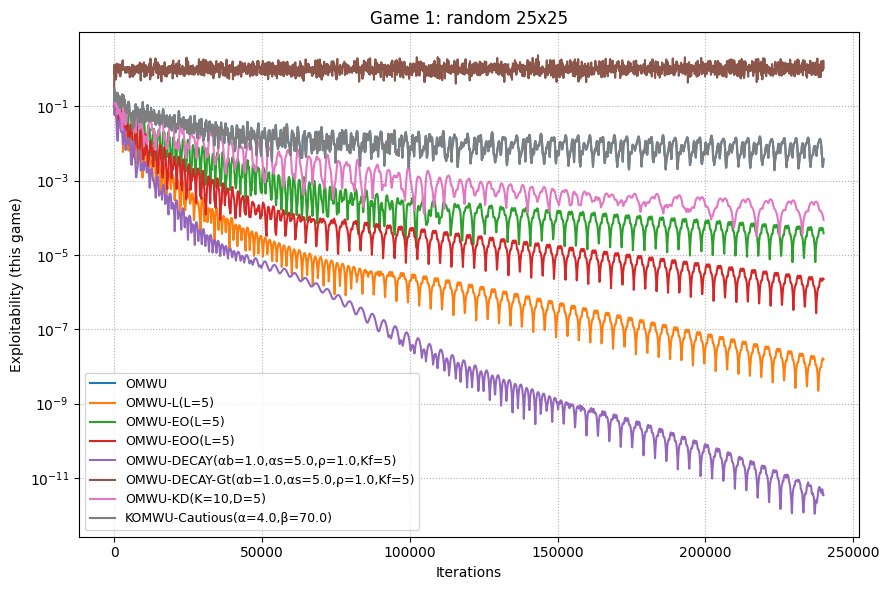

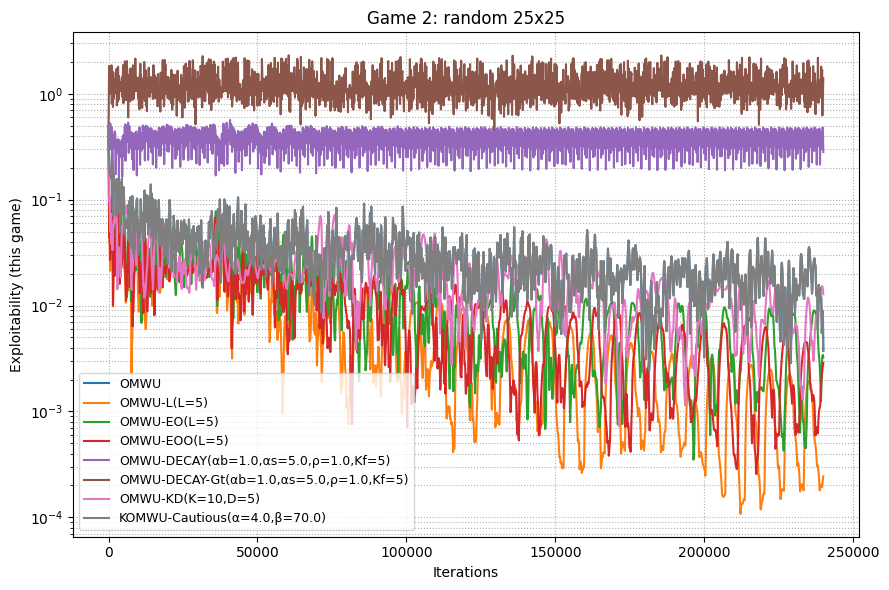

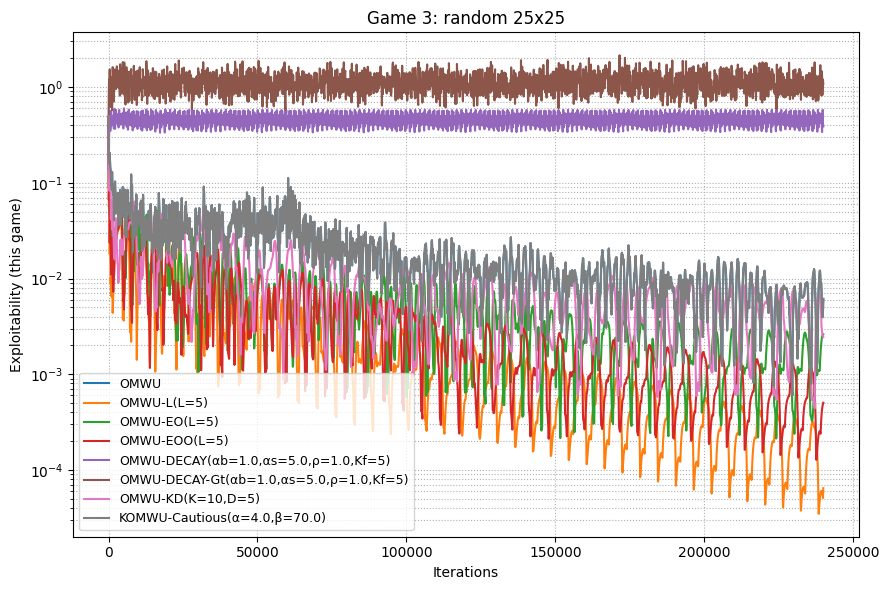

In [7]:
#!/usr/bin/env python3
"""
Standalone: runs OMWU variants on random 5x5 zero-sum games and plots results.

Variants implemented (directions d_t exactly as specified by user):
- OMWU:                d_t = 2 g_t − g_{t−1}
- OMWU-L:              d_t = (L+1) g_t − sum_{i=1}^L g_{t−i}
- OMWU-EO:             d_t = (L+1) g_t − L g_{t−1}
- OMWU-EOO:            d_t = (L+1) g_t − g_{t−1} − pending_t
                        pending_{t+1} = max(L−1,0) · g_{t−1}
- OMWU-DECAY:          d_t = α_b g_t − (α_b−1) g_{t−1}
                             + sum_{j=0}^{K_f−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
                        (ρ=1): d_t = (α_b+α_s) g_t − (α_b−1) g_{t−1} − α_s g_{t−K_f}
- OMWU-DECAY-Gt:       d_t = α_b g_t − (α_b−1) g_{t−1}
                             + sum_{j=0}^{K_f−1} α_s ρ^j (g_t − g_{t−j−1})
                        (ρ=1): d_t = (α_b + K_f α_s) g_t − α_s * sum_{j=1}^{K_f} g_{t−j}
- OMWU-KD:             per step: Δb_t = η (2 g_t − g_{t−1}); b += Δb_t
                        every K_win steps: b -= sum of the first D_drop increments from that window
- KOMWU-Cautious:      direction is 2 g_t − g_{t−1}, but step size λ_t ∈ (0, η]
                        chosen by maximizing f(λ;r_t) = (α−1) log λ + log Σ_i exp(λ r_{t,i})
                        with r_t = U_t + u_{t−1},  u_t = g_t − <g_t, x_t> · 1
                        and full-step guard if max(r_t) ≥ −β (log d)^2
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Callable, Dict, List, Tuple

# ========================== CONFIG (edit me) ==========================
@dataclass
class Config:
    n_actions: int = 25                 # 5x5 game
    n_games: int = 3                   # number of random games to average
    T: int = 240000                     # iterations per game
    eta: float = 0.1                   # base step size
    L: int = 5                         # breadth for *-L, EO, EOO
    alpha_b: float = 1.0               # DECAY base weight
    alpha_s: float = 5.0               # DECAY suffix weight
    rho: float = 1.0                   # DECAY geometric factor
    Kf: int = 5                        # DECAY filter length
    K_win: int = 10                    # KD window length
    D_drop: int = 5                    # KD drop count at each window end
    cautious_alpha: float = 4.0        # Cautious (α in f(λ))
    cautious_beta: float = 70.0        # Cautious (β threshold)
    cautious_newton_iters: int = 8     # Cautious Newton steps
    cautious_newton_tol: float = 1e-12 # Cautious Newton tol
    seed: int = 1                      # RNG seed
    print_every: int = 500             # progress print freq
    plot_every: int = 100              # curve sampling freq

CFG = Config()
# =====================================================================

# ============== numerics (stable softmax, helpers) ====================
def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    s = e / np.sum(e)
    return s

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    # g_row = A y
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    # g_col = -A^T x
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)  # since ev_col = -ev_row
    exploit = 0.5 * nconv
    return nconv, exploit

# ============================ base agent ==============================
class AgentBase:
    def __init__(self, n: int, eta: float, label: str):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.b = np.zeros(n, dtype=float)
        self.x = softmax(self.b)
        self.t = 0
        self.g_prev = np.zeros(n, dtype=float)  # g_{t-1}, zero if missing
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_grad(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, t_idx: int) -> np.ndarray:
        if t_idx <= 0 or t_idx > len(self._g_hist):
            return np.zeros(self.n, dtype=float)
        return self._g_hist[t_idx - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError

# ============================ variants ================================
class OMWU(AgentBase):
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-L(L={L})")
        self.L = int(L)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        sum_past = np.zeros(self.n, dtype=float)
        for i in range(1, self.L + 1):
            sum_past += self._get_g(self.t - i)
        d_t = (self.L + 1.0) * g_t - sum_past
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_EO(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-EO(L={L})")
        self.L = int(L)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - (self.L * self.g_prev)
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-EOO(L={L})")
        self.L = int(L)
        self.pending = np.zeros(n, dtype=float)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_grad(g_t)

class OMWU_DECAY(AgentBase):
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.alpha_b = float(alpha_b)
        self.alpha_s = float(alpha_s)
        self.rho = float(rho)
        self.Kf = int(Kf)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_DECAY_Gt(AgentBase):
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY-Gt(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.alpha_b = float(alpha_b)
        self.alpha_s = float(alpha_s)
        self.rho = float(rho)
        self.Kf = int(Kf)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tjm1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_t - g_tjm1)
        d_t = base + tail
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_KD(AgentBase):
    """
    Block-window KD: per step Δb_t = η (2 g_t − g_{t−1}); after each K_win steps,
    subtract the sum of the FIRST D_drop increments from that block (drop-first).
    Then start a fresh window.
    """
    def __init__(self, n: int, eta: float, K_win: int, D_drop: int):
        super().__init__(n, eta, f"OMWU-KD(K={K_win},D={D_drop})")
        self.K_win = int(K_win)
        self.D_drop = int(D_drop)
        self._win_increments: List[np.ndarray] = []
        self._steps_in_block = 0

    def _end_block_prune(self):
        drop = min(self.D_drop, len(self._win_increments))
        if drop > 0:
            to_sub = np.sum(self._win_increments[:drop], axis=0)
            self.b -= to_sub
        self._win_increments.clear()
        self._steps_in_block = 0
        self.x = softmax(self.b)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        delta_b = self.eta * d_t
        self.b += delta_b
        self._win_increments.append(delta_b)
        self._steps_in_block += 1
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)
        if self._steps_in_block >= self.K_win:
            self._end_block_prune()

class KOMWU_Cautious(AgentBase):
    """
    Same direction as OMWU: d_t = 2 g_t − g_{t−1}, but adaptive step λ_t ∈ (0, η]
    via f(λ; r) = (α−1) log λ + log sum_i exp(λ r_i),
    with r_t = U_t + u_{t−1}, u_t = g_t − <g_t, x_t> 1.
    Full step if max(r) ≥ −β (log d)^2.
    """
    def __init__(self, n: int, eta: float, alpha: float, beta: float, iters: int, tol: float):
        super().__init__(n, eta, f"KOMWU-Cautious(α={alpha},β={beta})")
        self.alpha = float(alpha)
        self.beta = float(beta)
        self.iters = int(iters)
        self.tol = float(tol)
        self._ones = np.ones(n, dtype=float)
        self._U = np.zeros(n, dtype=float)
        self._u_last = np.zeros(n, dtype=float)
        self._d_ref = n

    def _choose_lambda(self, r: np.ndarray) -> float:
        maxr = float(np.max(r))
        d = float(self._d_ref)
        thresh = - self.beta * (np.log(d) ** 2.0) if d > 1.0 else -self.beta
        if maxr >= thresh:
            return float(self.eta)
        eps = np.finfo(float).tiny
        lam = max((self.alpha - 1.0) / (-maxr + 1e-30), eps)
        lam = min(lam, float(self.eta))
        for _ in range(self.iters):
            z = lam * r
            m = float(np.max(z))
            e = np.exp(z - m)
            Z = float(np.sum(e))
            p = e / Z
            Er = float(p @ r)
            Er2 = float(p @ (r * r))
            Var = max(Er2 - Er * Er, 0.0)
            f1 = (self.alpha - 1.0) / lam + Er
            f2 = -(self.alpha - 1.0) / (lam * lam) + Var
            if f2 >= -1e-30:
                break
            new_lam = lam - f1 / f2
            new_lam = float(min(max(new_lam, eps), float(self.eta)))
            if abs(new_lam - lam) <= self.tol * max(1.0, lam):
                lam = new_lam
                break
            lam = new_lam
        return float(lam)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        x_t = self.x
        gt_bar = float(g_t @ x_t)
        u_t = g_t - gt_bar * self._ones
        r_t = self._U + self._u_last
        lam_t = self._choose_lambda(r_t)
        d_t = 2.0 * g_t - self.g_prev
        self.b += lam_t * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._U += u_t
        self._u_last = u_t.copy()
        self._push_grad(g_t)

# ========================== experiment harness =========================
def make_random_zero_sum_game(n: int, rng: np.random.Generator) -> np.ndarray:
    return rng.normal(0.0, 1.0, size=(n, n)).astype(float)

def build_agents(n: int, cfg: Config) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}

    def pair(factory: Callable[[], AgentBase]) -> Tuple[AgentBase, AgentBase]:
        a = factory()
        b = factory()
        return a, b

    agents["OMWU"] = pair(lambda: OMWU(n, cfg.eta, "OMWU"))
    agents[f"OMWU-L(L={cfg.L})"] = pair(lambda: OMWU_L(n, cfg.eta, cfg.L))
    agents[f"OMWU-EO(L={cfg.L})"] = pair(lambda: OMWU_EO(n, cfg.eta, cfg.L))
    agents[f"OMWU-EOO(L={cfg.L})"] = pair(lambda: OMWU_EOO(n, cfg.eta, cfg.L))
    agents[f"OMWU-DECAY(αb={cfg.alpha_b},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
        lambda: OMWU_DECAY(n, cfg.eta, cfg.alpha_b, cfg.alpha_s, cfg.rho, cfg.Kf)
    )
    agents[f"OMWU-DECAY-Gt(αb={cfg.alpha_b},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
        lambda: OMWU_DECAY_Gt(n, cfg.eta, cfg.alpha_b, cfg.alpha_s, cfg.rho, cfg.Kf)
    )
    agents[f"OMWU-KD(K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: OMWU_KD(n, cfg.eta, cfg.K_win, cfg.D_drop)
    )
    agents[f"KOMWU-Cautious(α={cfg.cautious_alpha},β={cfg.cautious_beta})"] = pair(
        lambda: KOMWU_Cautious(n, cfg.eta, cfg.cautious_alpha, cfg.cautious_beta,
                               cfg.cautious_newton_iters, cfg.cautious_newton_tol)
    )
    return agents

def sampling_times(cfg: Config) -> List[int]:
    # Align with logging rule: we record at t==1 and at each multiple of plot_every.
    return [1] + list(range(cfg.plot_every, cfg.T + 1, cfg.plot_every))

def run_one_game(A: np.ndarray, cfg: Config, rng: np.random.Generator):
    n = A.shape[0]
    agents = build_agents(n, cfg)

    times = sampling_times(cfg)
    records = {lbl: {"times": [], "exploit": []} for lbl in agents.keys()}

    for t in range(1, cfg.T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy()
            y = col.next_strategy()
            g_row = row_grad(A, y)
            g_col = col_grad(A, x)
            row.observe_gradient(g_row)
            col.observe_gradient(g_col)

            if t == 1 or (t % cfg.plot_every) == 0:
                x2 = row.next_strategy()
                y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t)
                records[lbl]["exploit"].append(ex)

        if (t % cfg.print_every) == 0 or t == 1:
            msg = [f"t={t:6d}"]
            for lbl in agents.keys():
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # Sanity: align lengths
    for lbl in records:
        if len(records[lbl]["times"]) != len(times):
            # make sure plotting won't crash; this should not trigger now
            min_len = min(len(records[lbl]["times"]), len(records[lbl]["exploit"]), len(times))
            records[lbl]["times"] = records[lbl]["times"][:min_len]
            records[lbl]["exploit"] = records[lbl]["exploit"][:min_len]

    return times, records

def aggregate_results(all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]]) -> Dict[str, Dict[str, np.ndarray]]:
    labels = list(all_runs[0][1].keys())
    # assume same times schedule for all runs
    times = np.array(all_runs[0][0], dtype=float)
    agg = {lbl: {"times": times.copy(),
                 "exploit_mean": np.zeros_like(times),
                 "exploit_std": np.zeros_like(times)} for lbl in labels}
    for lbl in labels:
        mat = []
        for times_i, rec in all_runs:
            ys = np.array(rec[lbl]["exploit"], dtype=float)
            if ys.shape[0] != times.shape[0]:
                # truncate/pad if needed (shouldn't happen with fixed sampling)
                m = min(len(ys), len(times))
                ys = ys[:m]
            mat.append(ys)
        M = np.vstack(mat)
        agg[lbl]["exploit_mean"] = M.mean(axis=0)
        agg[lbl]["exploit_std"]  = M.std(axis=0)
    return agg

def main():
    print("Config:", asdict(CFG))
    rng = np.random.default_rng(CFG.seed)
    all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]] = []
    per_game_records: List[Tuple[int, List[int], Dict[str, Dict[str, List[float]]], np.ndarray]] = []

    for g in range(1, CFG.n_games + 1):
        A = rng.normal(0.0, 1.0, size=(CFG.n_actions, CFG.n_actions)).astype(float)
        print(f"\n=== Game {g}/{CFG.n_games} (random {CFG.n_actions}x{CFG.n_actions}) ===")
        times, records = run_one_game(A, CFG, rng)
        all_runs.append((times, records))
        per_game_records.append((g, times, records, A))

    # ---------- Aggregate plot ----------
    agg = aggregate_results(all_runs)
    plt.figure(figsize=(9,6))
    for lbl, data in agg.items():
        xs = data["times"]
        ys = data["exploit_mean"]
        plt.plot(xs, ys, label=lbl)
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel("Exploitability (average over games)")
    plt.title(f"OMWU variants on random {CFG.n_actions}x{CFG.n_actions} zero-sum games (n={CFG.n_games})")
    plt.grid(True, which="both", ls=":")
    plt.legend(fontsize=9, ncol=1)
    plt.tight_layout()
    plt.show()

    # ---------- Individual plots, one per game ----------
    for (g, times, records, A) in per_game_records:
        plt.figure(figsize=(9,6))
        for lbl, rec in records.items():
            xs = np.array(rec["times"], dtype=float)
            ys = np.array(rec["exploit"], dtype=float)
            plt.plot(xs, ys, label=lbl)
        plt.yscale("log")
        plt.xlabel("Iterations")
        plt.ylabel("Exploitability (this game)")
        plt.title(f"Game {g}: random {CFG.n_actions}x{CFG.n_actions}")
        plt.grid(True, which="both", ls=":")
        plt.legend(fontsize=9, ncol=1)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()


In [8]:
#######################################

Config: {'n_actions': 35, 'n_games': 1, 'T': 280000, 'eta': 0.1, 'L': 5, 'alpha_b': 1.0, 'alpha_s': 5.0, 'rho': 1.0, 'Kf': 5, 'K_win': 10, 'D_drop': 5, 'cautious_alpha': 4.0, 'cautious_beta': 70.0, 'cautious_newton_iters': 8, 'cautious_newton_tol': 1e-12, 'geo_gamma': 0.5, 'L_max': 5, 'ema_beta': 0.9, 'th_alpha_s1': 5.0, 'th_rho1': 1.0, 'th_Kf1': 5, 'th_alpha_s2': 2.0, 'th_rho2': 1.0, 'th_Kf2': 20, 'seed': 0, 'print_every': 500, 'plot_every': 100}

=== Game 1/1  seed=5874934615388537134  (random 35x35) ===
[progress] t=     1  OMWU: ex=3.164e-01  OMWU-L(L=5): ex=3.028e-01  OMWU-EO(L=5): ex=3.028e-01  OMWU-EOO(L=5): ex=3.028e-01  OMWU-KD(K=10,D=5): ex=3.164e-01  KOMWU-Cautious(α=4.0,β=70.0): ex=3.164e-01  OMWU-L+KD(L=5,K=10,D=5): ex=3.028e-01  OMWU-EO+KD(L=5,K=10,D=5): ex=3.028e-01  OMWU-EOO+KD(L=5,K=10,D=5): ex=3.028e-01  KOMWU-Cautious-L(L=5): ex=3.028e-01  KOMWU-Cautious-EO(L=5): ex=3.028e-01  KOMWU-Cautious+KD(K=10,D=5): ex=3.164e-01  OMWU-EO-Adapt(Lmax=5): ex=3.028e-01
[progress] t

/tmp/ipython-input-2750364901.py:586: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(labels))  # discrete sampling, repeats gracefully >20


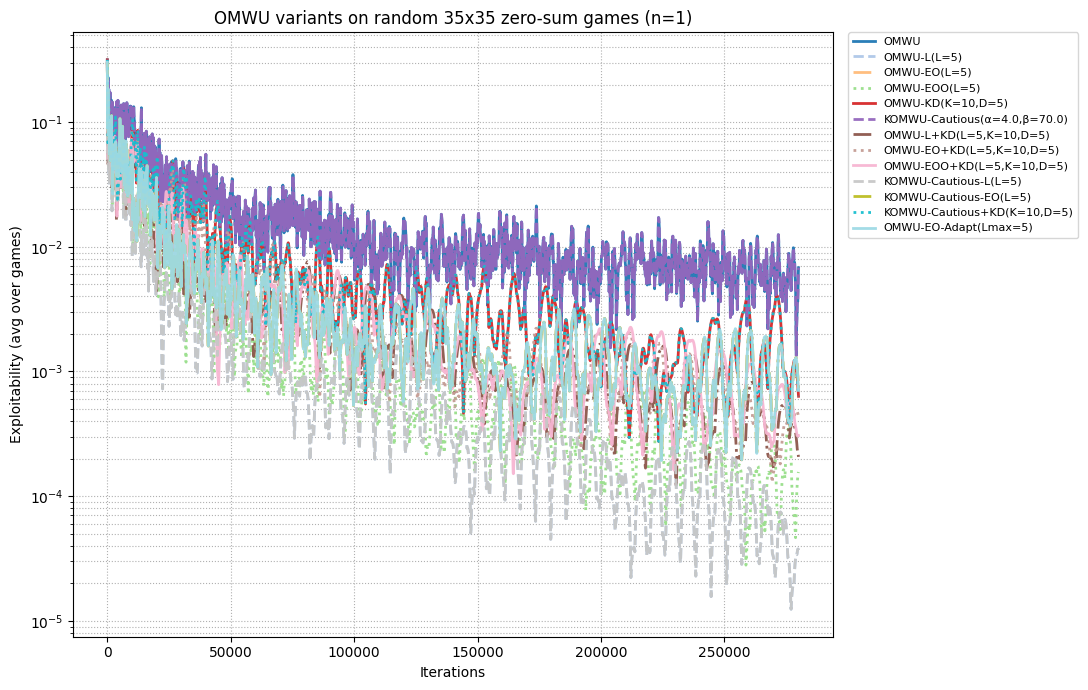

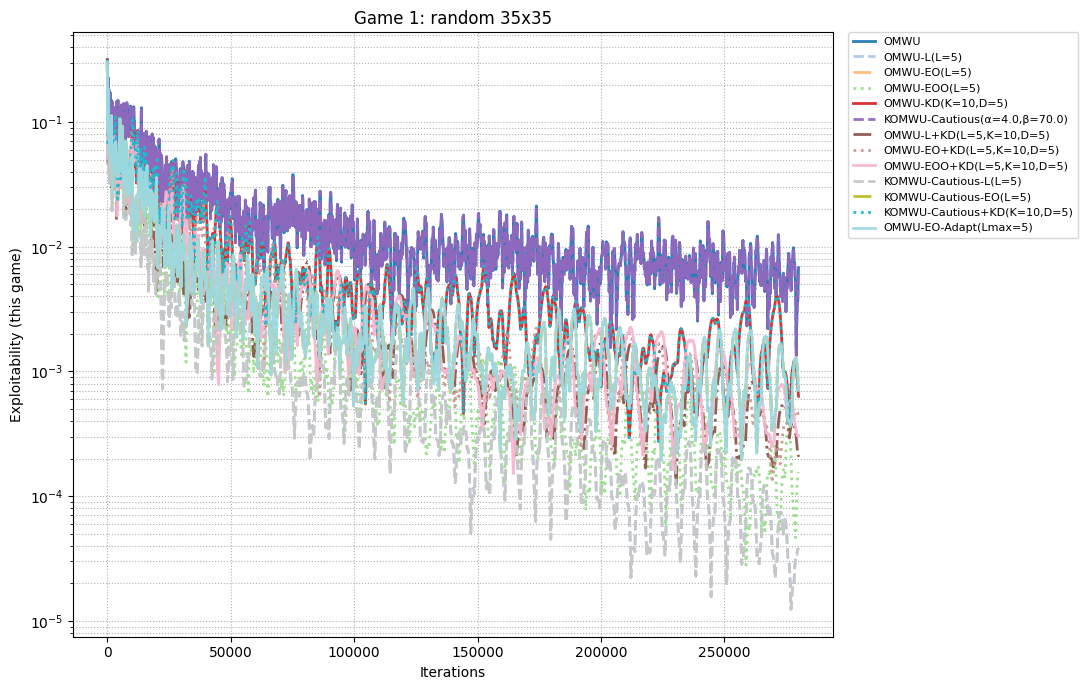

In [6]:
#!/usr/bin/env python3
"""
Standalone: OMWU family on random 5x5 zero-sum games, originals + new variants.
- DECAY-Gt variants removed per request.
- Prints the RNG seed used for each game.
- Distinct, consistent color+linestyle per variant across all plots.
- Per-game plots and an aggregate plot at the end.

Original variants (exact per user's spec, DECAY-Gt removed):
  OMWU:                d_t = 2 g_t − g_{t−1}
  OMWU-L:              d_t = (L+1) g_t − sum_{i=1}^L g_{t−i}
  OMWU-EO:             d_t = (L+1) g_t − L g_{t−1}
  OMWU-EOO:            d_t = (L+1) g_t − g_{t−1} − pending_t
                        pending_{t+1} = max(L−1,0) · g_{t−1}
  OMWU-DECAY:          d_t = α_b g_t − (α_b−1) g_{t−1}
                             + sum_{j=0}^{K_f−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
                        (ρ=1): d_t = (α_b+α_s) g_t − (α_b−1) g_{t−1} − α_s g_{t−K_f}
  OMWU-KD:             per step: Δb_t = η (2 g_t − g_{t−1}); b += Δb_t
                        every K_win steps: b -= sum of the first D_drop increments
  KOMWU-Cautious:      direction 2 g_t − g_{t−1}, adaptive step λ_t ∈ (0,η] from f(λ;r_t)

New variants included (mix & match of the same building blocks, still no DECAY-Gt):
  OMWU-DECAY-EO, OMWU-DECAY-L, OMWU-DECAY-EOO,
  KD-L, KD-EO, KD-EOO, DECAY-KD,
  KOMWU-Cautious-L, KOMWU-Cautious-EO, KOMWU-Cautious-KD,
  OMWU-EOO-Geo(γ), OMWU-EO-Adaptive(L_max),
  OMWU-EMA-BC (bias-corrected EMA tail),
  OMWU-DECAY-2H (two-horizon decay sums).
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Callable, Dict, List, Tuple

# ========================== CONFIG (edit me) ==========================
@dataclass
class Config:
    n_actions: int = 35           # 5x5 game
    n_games: int = 1             # number of random games
    T: int = 280000               # iterations per game
    eta: float = 0.1             # base step size

    # core breadth/decay defaults
    L: int = 5
    alpha_b: float = 1.0
    alpha_s: float = 5.0
    rho: float = 1.0
    Kf: int = 5

    # KD defaults
    K_win: int = 10
    D_drop: int = 5

    # cautious step defaults
    cautious_alpha: float = 4.0
    cautious_beta: float = 70.0
    cautious_newton_iters: int = 8
    cautious_newton_tol: float = 1e-12

    # extras for new variants
    geo_gamma: float = 0.5            # for OMWU-EOO-Geo
    L_max: int = 5                    # for OMWU-EO-Adaptive
    ema_beta: float = 0.9             # for OMWU-EMA-BC

    # two-horizon decay (2H)
    th_alpha_s1: float = 5.0
    th_rho1: float = 1.0
    th_Kf1: int = 5
    th_alpha_s2: float = 2.0
    th_rho2: float = 1.0
    th_Kf2: int = 20

    # logging / plotting
    seed: int = 0
    print_every: int = 500
    plot_every: int = 100

CFG = Config()
# =====================================================================

# ============== numerics (stable softmax, helpers) ====================
def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    s = e / np.sum(e)
    return s

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)
    exploit = 0.5 * nconv
    return nconv, exploit

# ============================ base agent ==============================
class AgentBase:
    def __init__(self, n: int, eta: float, label: str):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.b = np.zeros(n, dtype=float)
        self.x = softmax(self.b)
        self.t = 0
        self.g_prev = np.zeros(n, dtype=float)
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_grad(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, t_idx: int) -> np.ndarray:
        if t_idx <= 0 or t_idx > len(self._g_hist):
            return np.zeros(self.n, dtype=float)
        return self._g_hist[t_idx - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError

# ============================ originals ===============================
class OMWU(AgentBase):
    def __init__(self, n: int, eta: float):
        super().__init__(n, eta, "OMWU")
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-L(L={L})")
        self.L = int(L)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        sum_past = np.zeros(self.n, dtype=float)
        for i in range(1, self.L + 1):
            sum_past += self._get_g(self.t - i)
        d_t = (self.L + 1.0) * g_t - sum_past
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_EO(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-EO(L={L})")
        self.L = int(L)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - (self.L * self.g_prev)
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-EOO(L={L})")
        self.L = int(L)
        self.pending = np.zeros(n, dtype=float)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_grad(g_t)

class OMWU_DECAY(AgentBase):
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.alpha_b = float(alpha_b); self.alpha_s = float(alpha_s)
        self.rho = float(rho); self.Kf = int(Kf)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_KD(AgentBase):
    def __init__(self, n: int, eta: float, K_win: int, D_drop: int):
        super().__init__(n, eta, f"OMWU-KD(K={K_win},D={D_drop})")
        self.K_win = int(K_win); self.D_drop = int(D_drop)
        self._win_increments: List[np.ndarray] = []; self._steps_in_block = 0
    def _end_block_prune(self):
        drop = min(self.D_drop, len(self._win_increments))
        if drop > 0:
            to_sub = np.sum(self._win_increments[:drop], axis=0)
            self.b -= to_sub
        self._win_increments.clear(); self._steps_in_block = 0
        self.x = softmax(self.b)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        delta_b = self.eta * d_t
        self.b += delta_b
        self._win_increments.append(delta_b)
        self._steps_in_block += 1
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)
        if self._steps_in_block >= self.K_win:
            self._end_block_prune()

# ======================= cautious step base/class =====================
class KOMWU_Cautious(AgentBase):
    """
    Direction: 2 g_t − g_{t−1}, step λ_t ∈ (0, η] via f(λ;r_t).
    """
    def __init__(self, n: int, eta: float, alpha: float, beta: float, iters: int, tol: float):
        super().__init__(n, eta, f"KOMWU-Cautious(α={alpha},β={beta})")
        self.alpha = float(alpha); self.beta = float(beta)
        self.iters = int(iters); self.tol = float(tol)
        self._ones = np.ones(n, dtype=float); self._U = np.zeros(n, dtype=float); self._u_last = np.zeros(n, dtype=float)
        self._d_ref = n
    def _choose_lambda(self, r: np.ndarray) -> float:
        maxr = float(np.max(r)); d = float(self._d_ref)
        thresh = - self.beta * (np.log(d) ** 2.0) if d > 1.0 else -self.beta
        if maxr >= thresh: return float(self.eta)
        eps = np.finfo(float).tiny
        lam = max((self.alpha - 1.0) / (-maxr + 1e-30), eps); lam = min(lam, float(self.eta))
        for _ in range(self.iters):
            z = lam * r; m = float(np.max(z)); e = np.exp(z - m); Z = float(np.sum(e)); p = e / Z
            Er = float(p @ r); Er2 = float(p @ (r * r)); Var = max(Er2 - Er * Er, 0.0)
            f1 = (self.alpha - 1.0) / lam + Er; f2 = -(self.alpha - 1.0) / (lam * lam) + Var
            if f2 >= -1e-30: break
            new_lam = float(min(max(lam - f1 / f2, eps), float(self.eta)))
            if abs(new_lam - lam) <= self.tol * max(1.0, lam): lam = new_lam; break
            lam = new_lam
        return float(lam)
    def _lambda_step(self, g_t: np.ndarray, base_direction: np.ndarray):
        r_t = self._U + self._u_last
        lam_t = self._choose_lambda(r_t)
        self.b += lam_t * base_direction
        self.x = softmax(self.b)
        gt_bar = float(g_t @ self.x)
        u_t = g_t - gt_bar * self._ones
        self._U += u_t; self._u_last = u_t.copy()
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self._lambda_step(g_t, d_t)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

# Cautious on EO base
class KOMWU_Cautious_EO(KOMWU_Cautious):
    def __init__(self, n: int, eta: float, L: int, alpha: float, beta: float, iters: int, tol: float):
        super().__init__(n, eta, alpha, beta, iters, tol)
        self.L = int(L); self.label = f"KOMWU-Cautious-EO(L={L})"
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - (self.L * self.g_prev)
        self._lambda_step(g_t, d_t)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

# Cautious on L base
class KOMWU_Cautious_L(KOMWU_Cautious):
    def __init__(self, n: int, eta: float, L: int, alpha: float, beta: float, iters: int, tol: float):
        super().__init__(n, eta, alpha, beta, iters, tol)
        self.L = int(L); self.label = f"KOMWU-Cautious-L(L={L})"
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        sum_past = np.zeros(self.n, dtype=float)
        for i in range(1, self.L + 1):
            sum_past += self._get_g(self.t - i)
        d_t = (self.L + 1.0) * g_t - sum_past
        self._lambda_step(g_t, d_t)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

# ================= new base/combination directions ====================
# DECAY + EO base
class OMWU_DECAY_EO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY-EO(L={L},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.L = int(L); self.alpha_s = float(alpha_s); self.rho = float(rho); self.Kf = int(Kf)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.L + 1.0) * g_t - (self.L * self.g_prev)
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# DECAY + L base
class OMWU_DECAY_L_base(AgentBase):
    def __init__(self, n: int, eta: float, L: int, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY-L(L={L},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.L = int(L); self.alpha_s = float(alpha_s); self.rho = float(rho); self.Kf = int(Kf)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        sum_past = np.zeros(self.n, dtype=float)
        for i in range(1, self.L + 1):
            sum_past += self._get_g(self.t - i)
        base = (self.L + 1.0) * g_t - sum_past
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# DECAY + EOO base
class OMWU_DECAY_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY-EOO(L={L},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.L = int(L); self.alpha_s = float(alpha_s); self.rho = float(rho); self.Kf = int(Kf)
        self.pending = np.zeros(n, dtype=float)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.L + 1.0) * g_t - self.g_prev - self.pending
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t; self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy(); self.pending = new_pending; self._push_grad(g_t)

# EOO with geometric pending
class OMWU_EOO_Geo(AgentBase):
    def __init__(self, n: int, eta: float, L: int, gamma: float):
        super().__init__(n, eta, f"OMWU-EOO-Geo(L={L},γ={gamma})")
        self.L = int(L); self.gamma = float(gamma)
        self.pending = np.zeros(n, dtype=float)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.pending = self.gamma * self.pending + max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# Adaptive EO breadth
class OMWU_EO_Adaptive(AgentBase):
    def __init__(self, n: int, eta: float, L_max: int):
        super().__init__(n, eta, f"OMWU-EO-Adapt(Lmax={L_max})")
        self.L_max = int(L_max)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        align = float(g_t @ self.g_prev)
        L_t = self.L_max if align >= 0.0 else 1
        d_t = (L_t + 1.0) * g_t - (L_t * self.g_prev)
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# Bias-corrected EMA tail (not DECAY-Gt)
class OMWU_EMA_BC(AgentBase):
    """
    EMA S_t = β S_{t-1} + (1-β) g_t, debiased Ŝ_t = S_t / (1-β^t).
    d_t = α_b g_t − (α_b−1) g_{t−1} + α_s (Ŝ_t − g_t).
    """
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, beta: float):
        super().__init__(n, eta, f"OMWU-EMA-BC(αb={alpha_b},αs={alpha_s},β={beta})")
        self.alpha_b = float(alpha_b); self.alpha_s = float(alpha_s); self.beta = float(beta)
        self.S = np.zeros(n, dtype=float)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        self.S = self.beta * self.S + (1.0 - self.beta) * g_t
        debias = 1.0 - (self.beta ** self.t)
        S_hat = self.S / max(debias, 1e-30)
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = self.alpha_s * (S_hat - g_t)
        d_t = base + tail
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# Two-horizon decay: sum of two finite-diff tails
class OMWU_DECAY_2H(AgentBase):
    """
    d_t = α_b g_t − (α_b−1) g_{t−1}
          + sum_{j=0}^{Kf1−1} α_s1 ρ1^j (g_{t−j} − g_{t−j−1})
          + sum_{j=0}^{Kf2−1} α_s2 ρ2^j (g_{t−j} − g_{t−j−1})
    """
    def __init__(self, n: int, eta: float, alpha_b: float,
                 alpha_s1: float, rho1: float, Kf1: int,
                 alpha_s2: float, rho2: float, Kf2: int):
        super().__init__(n, eta,
            f"OMWU-DECAY-2H(αb={alpha_b}; αs1={alpha_s1},ρ1={rho1},K1={Kf1}; αs2={alpha_s2},ρ2={rho2},K2={Kf2})")
        self.alpha_b = float(alpha_b)
        self.alpha_s1 = float(alpha_s1); self.rho1 = float(rho1); self.Kf1 = int(Kf1)
        self.alpha_s2 = float(alpha_s2); self.rho2 = float(rho2); self.Kf2 = int(Kf2)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf1):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s1 * (self.rho1 ** j)) * (g_tj - g_tj1)
        for j in range(0, self.Kf2):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s2 * (self.rho2 ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# ====================== KD wrapper for any agent ======================
class KDWrapper(AgentBase):
    """
    Wrap any AgentBase and apply KD pruning on its logits.
    We capture per-step Δb by diffing inner.b before/after.
    """
    def __init__(self, inner_factory: Callable[[], AgentBase], K_win: int, D_drop: int, label_prefix: str):
        inner = inner_factory()
        super().__init__(inner.n, inner.eta, f"{label_prefix}+KD(K={K_win},D={D_drop})")
        self.inner = inner
        self.K_win = int(K_win); self.D_drop = int(D_drop)
        self._win_increments: List[np.ndarray] = []; self._steps_in_block = 0
    def next_strategy(self) -> np.ndarray: return self.inner.next_strategy()
    def observe_gradient(self, g_t: np.ndarray):
        b_before = self.inner.b.copy()
        self.inner.observe_gradient(g_t)
        delta_b = self.inner.b - b_before
        self._win_increments.append(delta_b); self._steps_in_block += 1
        if self._steps_in_block >= self.K_win:
            drop = min(self.D_drop, len(self._win_increments))
            if drop > 0:
                to_sub = np.sum(self._win_increments[:drop], axis=0)
                self.inner.b -= to_sub
                self.inner.x = softmax(self.inner.b)
            self._win_increments.clear(); self._steps_in_block = 0

# ========================== experiment harness ========================
def make_random_zero_sum_game(n: int, rng: np.random.Generator) -> np.ndarray:
    return rng.normal(0.0, 1.0, size=(n, n)).astype(float)

def build_agents(n: int, cfg: Config) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}
    def pair(factory: Callable[[], AgentBase]) -> Tuple[AgentBase, AgentBase]:
        a = factory(); b = factory(); return a, b

    # originals (DECAY-Gt removed)
    agents["OMWU"] = pair(lambda: OMWU(n, cfg.eta))
    agents[f"OMWU-L(L={cfg.L})"] = pair(lambda: OMWU_L(n, cfg.eta, cfg.L))
    agents[f"OMWU-EO(L={cfg.L})"] = pair(lambda: OMWU_EO(n, cfg.eta, cfg.L))
    agents[f"OMWU-EOO(L={cfg.L})"] = pair(lambda: OMWU_EOO(n, cfg.eta, cfg.L))
    # agents[f"OMWU-DECAY(αb={cfg.alpha_b},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
    #     lambda: OMWU_DECAY(n, cfg.eta, cfg.alpha_b, cfg.alpha_s, cfg.rho, cfg.Kf)
    # )
    agents[f"OMWU-KD(K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: OMWU_KD(n, cfg.eta, cfg.K_win, cfg.D_drop)
    )
    agents[f"KOMWU-Cautious(α={cfg.cautious_alpha},β={cfg.cautious_beta})"] = pair(
        lambda: KOMWU_Cautious(n, cfg.eta, cfg.cautious_alpha, cfg.cautious_beta,
                               cfg.cautious_newton_iters, cfg.cautious_newton_tol)
    )

    ###########D0
    # new combos (all DECAY-Gt references removed)
    # agents[f"OMWU-DECAY-EO(L={cfg.L},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
    #     lambda: OMWU_DECAY_EO(n, cfg.eta, cfg.L, cfg.alpha_s, cfg.rho, cfg.Kf)
    # )
    # agents[f"OMWU-DECAY-L(L={cfg.L},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
    #     lambda: OMWU_DECAY_L_base(n, cfg.eta, cfg.L, cfg.alpha_s, cfg.rho, cfg.Kf)
    # )
    # agents[f"OMWU-DECAY-EOO(L={cfg.L},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
    #     lambda: OMWU_DECAY_EOO(n, cfg.eta, cfg.L, cfg.alpha_s, cfg.rho, cfg.Kf)
    # )

    # # KD wrappers for other bases
    agents[f"OMWU-L+KD(L={cfg.L},K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: KDWrapper(lambda: OMWU_L(n, cfg.eta, cfg.L), cfg.K_win, cfg.D_drop, f"OMWU-L(L={cfg.L})")
    )
    agents[f"OMWU-EO+KD(L={cfg.L},K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: KDWrapper(lambda: OMWU_EO(n, cfg.eta, cfg.L), cfg.K_win, cfg.D_drop, f"OMWU-EO(L={cfg.L})")
    )
    agents[f"OMWU-EOO+KD(L={cfg.L},K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: KDWrapper(lambda: OMWU_EOO(n, cfg.eta, cfg.L), cfg.K_win, cfg.D_drop, f"OMWU-EOO(L={cfg.L})")
    )
    # agents[f"OMWU-DECAY+KD(K={cfg.K_win},D={cfg.D_drop})"] = pair(
    #     lambda: KDWrapper(lambda: OMWU_DECAY(n, cfg.eta, cfg.alpha_b, cfg.alpha_s, cfg.rho, cfg.Kf),
    #                       cfg.K_win, cfg.D_drop, "OMWU-DECAY")
    # )

    ###########D9

    # cautious on other bases
    agents[f"KOMWU-Cautious-L(L={cfg.L})"] = pair(
        lambda: KOMWU_Cautious_L(n, cfg.eta, cfg.L, cfg.cautious_alpha, cfg.cautious_beta,
                                 cfg.cautious_newton_iters, cfg.cautious_newton_tol)
    )
    agents[f"KOMWU-Cautious-EO(L={cfg.L})"] = pair(
        lambda: KOMWU_Cautious_EO(n, cfg.eta, cfg.L, cfg.cautious_alpha, cfg.cautious_beta,
                                  cfg.cautious_newton_iters, cfg.cautious_newton_tol)
    )
    agents[f"KOMWU-Cautious+KD(K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: KDWrapper(lambda: KOMWU_Cautious(n, cfg.eta, cfg.cautious_alpha, cfg.cautious_beta,
                                                 cfg.cautious_newton_iters, cfg.cautious_newton_tol),
                          cfg.K_win, cfg.D_drop, "KOMWU-Cautious")
    )

    # # geo pending / adaptive EO / EMA-BC / two-horizon
    # agents[f"OMWU-EOO-Geo(L={cfg.L},γ={cfg.geo_gamma})"] = pair(
    #     lambda: OMWU_EOO_Geo(n, cfg.eta, cfg.L, cfg.geo_gamma)
    # )
    agents[f"OMWU-EO-Adapt(Lmax={cfg.L_max})"] = pair(
        lambda: OMWU_EO_Adaptive(n, cfg.eta, cfg.L_max)
    )
    # agents[f"OMWU-EMA-BC(β={cfg.ema_beta})"] = pair(
    #     lambda: OMWU_EMA_BC(n, cfg.eta, cfg.alpha_b, cfg.alpha_s, cfg.ema_beta)
    # )
    # agents["OMWU-DECAY-2H"] = pair(
    #     lambda: OMWU_DECAY_2H(n, cfg.eta, cfg.alpha_b,
    #                           cfg.th_alpha_s1, cfg.th_rho1, cfg.th_Kf1,
    #                           cfg.th_alpha_s2, cfg.th_rho2, cfg.th_Kf2)
    # )
    return agents

def sampling_times(cfg: Config) -> List[int]:
    return [1] + list(range(cfg.plot_every, cfg.T + 1, cfg.plot_every))

def run_one_game(A: np.ndarray, cfg: Config):
    agents = build_agents(A.shape[0], cfg)
    times = sampling_times(cfg)
    records = {lbl: {"times": [], "exploit": []} for lbl in agents.keys()}

    for t in range(1, cfg.T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy(); y = col.next_strategy()
            g_row = row_grad(A, y); g_col = col_grad(A, x)
            row.observe_gradient(g_row); col.observe_gradient(g_col)
            if t == 1 or (t % cfg.plot_every) == 0:
                x2 = row.next_strategy(); y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t); records[lbl]["exploit"].append(ex)
        if (t % cfg.print_every) == 0 or t == 1:
            msg = [f"t={t:6d}"]
            for lbl in agents.keys():
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # align lengths (safety)
    Tref = len(times)
    for lbl in records:
        if len(records[lbl]["times"]) != Tref:
            m = min(len(records[lbl]["times"]), len(records[lbl]["exploit"]), Tref)
            records[lbl]["times"] = records[lbl]["times"][:m]
            records[lbl]["exploit"] = records[lbl]["exploit"][:m]
    return times, records

# ---------- plotting helpers: consistent styles across figures ----------
def make_style_map(labels: List[str]):
    # Build a long, distinct palette and rotate linestyles for extra separation.
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab20', len(labels))  # discrete sampling, repeats gracefully >20
    linestyles = ['-', '--', '-.', ':']
    style_map = {}
    for i, lbl in enumerate(labels):
        color = cmap(i)
        ls = linestyles[i % len(linestyles)]
        style_map[lbl] = dict(color=color, linestyle=ls, linewidth=2.0, alpha=0.95)
    return style_map

def plot_aggregate(all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]], style_map: Dict[str, dict], cfg: Config):
    labels = list(all_runs[0][1].keys())
    times = np.array(all_runs[0][0], dtype=float)
    # aggregate
    agg_mean = {lbl: [] for lbl in labels}
    for lbl in labels:
        mat = []
        for _, rec in all_runs:
            ys = np.array(rec[lbl]["exploit"], dtype=float)
            m = min(len(ys), len(times))
            mat.append(ys[:m])
        M = np.vstack(mat)
        agg_mean[lbl] = M.mean(axis=0)

    plt.figure(figsize=(11, 7))
    for lbl in labels:
        ys = agg_mean[lbl]
        style = style_map[lbl]
        plt.plot(times[:len(ys)], ys, label=lbl, **style)
    plt.yscale("log")
    plt.xlabel("Iterations"); plt.ylabel("Exploitability (avg over games)")
    plt.title(f"OMWU variants on random {cfg.n_actions}x{cfg.n_actions} zero-sum games (n={cfg.n_games})")
    plt.grid(True, which="both", ls=":")
    # larger legend outside the plot area for readability
    plt.legend(fontsize=8, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

def plot_per_game(per_game: List[Tuple[int, List[int], Dict[str, Dict[str, List[float]]], np.ndarray]], style_map: Dict[str, dict], cfg: Config):
    for (g, times, records, A) in per_game:
        plt.figure(figsize=(11, 7))
        for lbl, rec in records.items():
            xs = np.array(rec["times"], dtype=float)
            ys = np.array(rec["exploit"], dtype=float)
            style = style_map[lbl]
            plt.plot(xs, ys, label=lbl, **style)
        plt.yscale("log")
        plt.xlabel("Iterations"); plt.ylabel("Exploitability (this game)")
        plt.title(f"Game {g}: random {cfg.n_actions}x{cfg.n_actions}")
        plt.grid(True, which="both", ls=":")
        plt.legend(fontsize=8, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
        plt.tight_layout()
        plt.show()

# =============================== main =================================
def main():
    print("Config:", asdict(CFG))
    base_rng = np.random.default_rng(CFG.seed)
    all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]] = []
    per_game: List[Tuple[int, List[int], Dict[str, Dict[str, List[float]]], np.ndarray]] = []

    for g in range(1, CFG.n_games + 1):
        game_seed = int(base_rng.integers(0, 2**63 - 1))
        game_rng = np.random.default_rng(game_seed)
        A = make_random_zero_sum_game(CFG.n_actions, game_rng)
        print(f"\n=== Game {g}/{CFG.n_games}  seed={game_seed}  (random {CFG.n_actions}x{CFG.n_actions}) ===")
        times, records = run_one_game(A, CFG)
        all_runs.append((times, records))
        per_game.append((g, times, records, A))

    # Build a consistent style map (based on first run's labels)
    labels = list(all_runs[0][1].keys())
    style_map = make_style_map(labels)

    # Aggregate + per-game plots
    plot_aggregate(all_runs, style_map, CFG)
    plot_per_game(per_game, style_map, CFG)

if __name__ == "__main__":
    main()


In [7]:
######################################################
######################################################

GlobalConfig: {'n_games_per_type': 3, 'T': 4001, 'print_every': 500, 'plot_every': 100, 'seed': 0, 'dtype': 'float64'}
VariantConfig: {'OMWU': {'eta': 0.7}, 'OMWU-L': {'eta': 0.3, 'L': 3}, 'OMWU-EO': {'eta': 0.3, 'L': 3}, 'OMWU-EOO': {'eta': 0.3, 'L': 3}, 'OMWU-DECAY': {'eta': 0.3, 'alpha_b': 1.0, 'alpha_s': 3.0, 'rho': 1.0, 'Kf': 4}}

=== random_5  |  game 1/3  |  seed=5874934615388537134  |  n=5 ===
[progress] t=     1  OMWU: ex=2.874e-01  OMWU-L(L=3): ex=3.033e-01  OMWU-EO(L=3): ex=3.033e-01  OMWU-EOO(L=3): ex=3.033e-01  OMWU-DECAY(αb=1.0,αs=3.0,ρ=1.0,Kf=4): ex=3.033e-01
[progress] t=   500  OMWU: ex=8.279e-08  OMWU-L(L=3): ex=2.396e-11  OMWU-EO(L=3): ex=3.771e-07  OMWU-EOO(L=3): ex=1.861e-10  OMWU-DECAY(αb=1.0,αs=3.0,ρ=1.0,Kf=4): ex=1.904e-01
[progress] t=  1000  OMWU: ex=1.685e-13  OMWU-L(L=3): ex=3.005e-15  OMWU-EO(L=3): ex=4.614e-12  OMWU-EOO(L=3): ex=3.095e-15  OMWU-DECAY(αb=1.0,αs=3.0,ρ=1.0,Kf=4): ex=2.545e-01
[progress] t=  1500  OMWU: ex=4.191e-15  OMWU-L(L=3): ex=3.067e-15 

/tmp/ipython-input-836999885.py:385: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(labels))


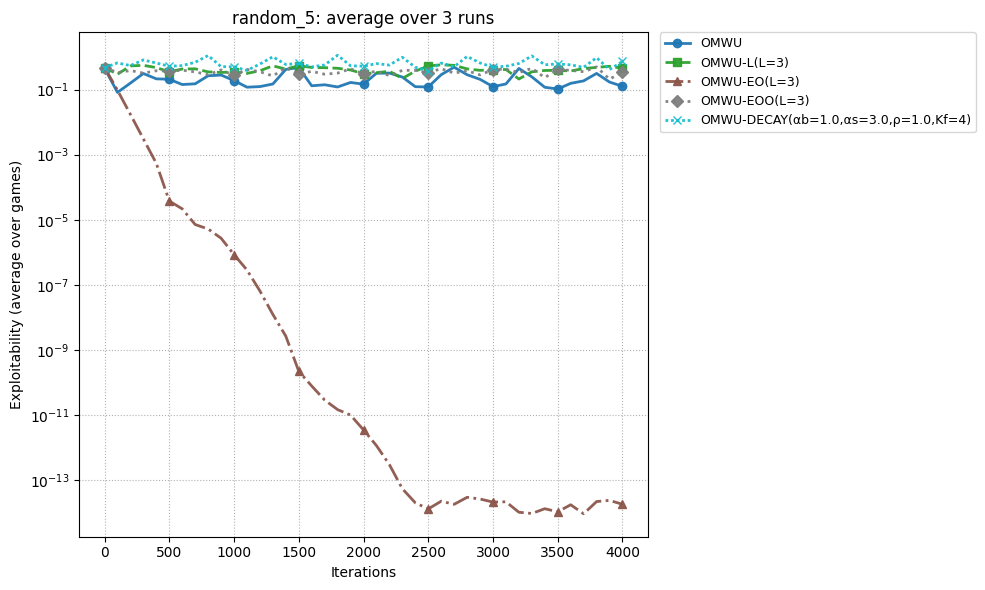

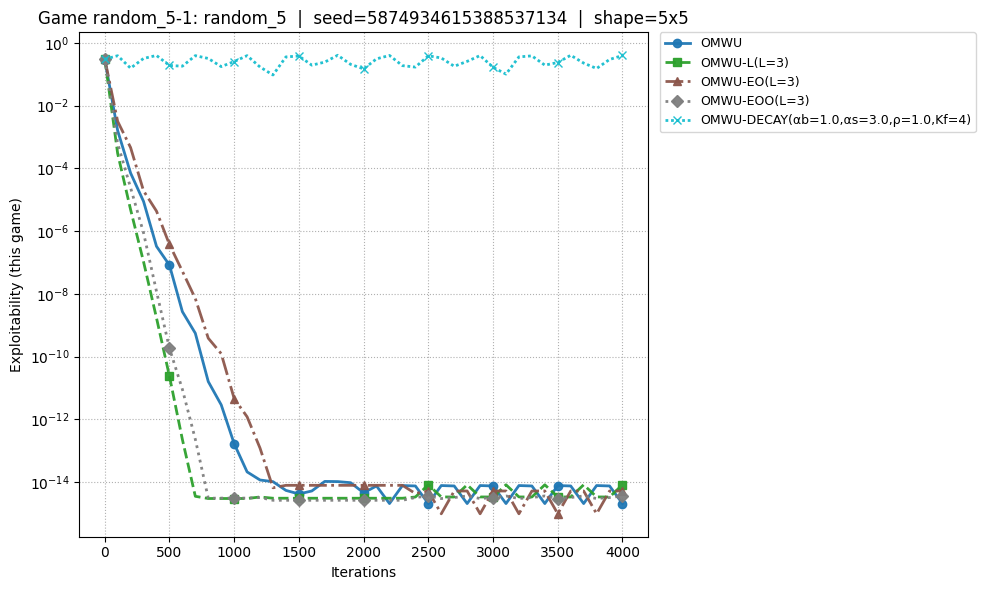

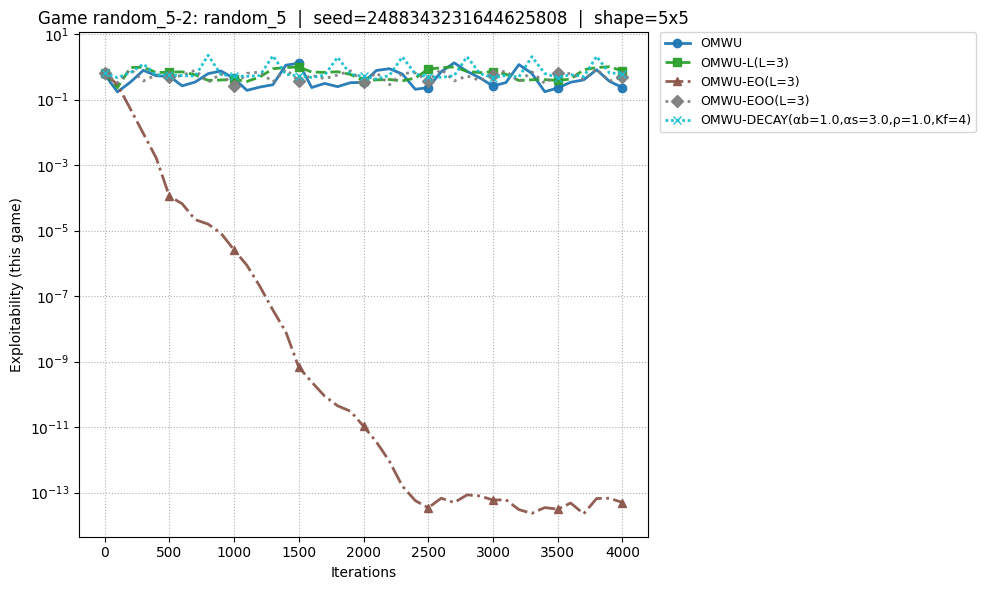

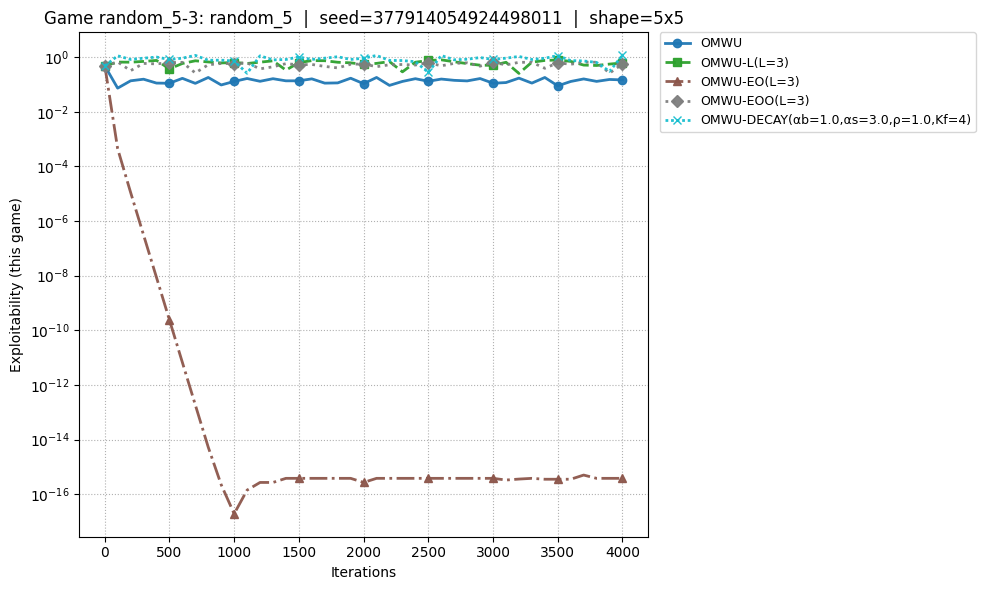

In [54]:
#!/usr/bin/env python3
"""
OMWU / L / EO / EOO / DECAY on five zero-sum game types.
- Per-variant hyperparameters (η, L, α_b, α_s, ρ, K_f) are independently configurable.
- Prints progress (with seeds), per-game plots, and an aggregate plot.
- Distinct color+linestyle per variant, consistent across figures.

Game types included:
  1) biased_rps_3    (3x3 biased Rock–Paper–Scissors)
  2) rpsls_5         (5x5 Rock–Paper–Scissors–Lizard–Spock ; non-vanilla RPS)
  3) cyclic_5        (5x5 cyclic / Shapley-style)
  4) lowrank_5       (5x5 low-rank, structured)
  5) random_5        (5x5 Gaussian random)

Row payoff = A; Column payoff = -A.
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Callable

# ========================= USER CONFIG (edit me) =========================

@dataclass
class GlobalConfig:
    # how many different instances (seeds) per game type
    n_games_per_type: int = 3
    # iterations per run
    T: int = 4001
    # logging / sampling
    print_every: int = 500
    plot_every: int = 100
    # master RNG seed
    seed: int = 0
    # numeric dtype
    dtype: str = "float64"  # "float64" or "longdouble"

GC = GlobalConfig()

# Per-variant independent hyperparameters.
# You can change η for each variant separately and (where applicable) L, α_b, α_s, ρ, K_f.
VARIANT_CFG = {
    "OMWU":        {"eta": 0.7},
    "OMWU-L":      {"eta": 0.3, "L": 3},
    "OMWU-EO":     {"eta": 0.3, "L": 3},
    "OMWU-EOO":    {"eta": 0.3, "L": 3},
    "OMWU-DECAY":  {"eta": 0.3, "alpha_b": 1.0, "alpha_s": 3.0, "rho": 1.0, "Kf": 4},
}

# Which game types to run (from the five defined below)
GAME_TYPES = ["random_5"] #["biased_rps_3"] #, "rpsls_5", "cyclic_5", "lowrank_5", "random_5"]

# ========================================================================


# ============================ numerics helpers ===========================

def get_dtype(name: str):
    if name == "float64":
        return np.float64
    elif name == "longdouble":
        return np.longdouble
    raise ValueError("dtype must be 'float64' or 'longdouble'")

def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    s = e / np.sum(e)
    return s

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)
    exploit = 0.5 * nconv
    return nconv, exploit


# ================================ agents =================================

class AgentBase:
    def __init__(self, n: int, eta: float, label: str, DTYPE):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.DTYPE = DTYPE
        self.b = np.zeros(n, dtype=DTYPE)
        self.x = softmax(self.b)
        self.g_prev = np.zeros(n, dtype=DTYPE)
        self.t = 0
        # a general gradient history (most recent at end); we use helpers to fetch safely
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_g(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, t_idx_from_1: int) -> np.ndarray:
        # t_idx_from_1==len(_g_hist) → last
        if t_idx_from_1 <= 0 or t_idx_from_1 > len(self._g_hist):
            return np.zeros(self.n, dtype=self.DTYPE)
        return self._g_hist[t_idx_from_1 - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError


# ------------------------------ OMWU --------------------------------------

class OMWU(AgentBase):
    def __init__(self, n: int, eta: float, DTYPE):
        super().__init__(n, eta, "OMWU", DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)


# ------------------------------ OMWU-L ------------------------------------

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-L(L={L})", DTYPE)
        self.L = int(L)
        self._histL: List[np.ndarray] = []
        self._sumL = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.DTYPE(self.L) + 1.0) * g_t - self._sumL
        d_t = base
        # update window sums after using
        self._histL.insert(0, g_t.copy())
        self._sumL += g_t
        if len(self._histL) > self.L:
            old = self._histL.pop()
            self._sumL -= old
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)


# ------------------------------ OMWU-EO -----------------------------------

class OMWU_EO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EO(L={L})", DTYPE)
        self.L = int(L)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - (self.DTYPE(self.L) * self.g_prev)
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)


# ------------------------------ OMWU-EOO ----------------------------------

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EOO(L={L})", DTYPE)
        self.L = int(L)
        self.pending = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_g(g_t)


# ------------------------------ OMWU-DECAY --------------------------------

class OMWU_DECAY(AgentBase):
    """
    d_t = α_b g_t − (α_b−1) g_{t−1} + sum_{j=0}^{Kf−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
    g_{t-k} := 0 if missing.
    """
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int, DTYPE):
        label = f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})"
        super().__init__(n, eta, label, DTYPE)
        self.alpha_b = DTYPE(alpha_b)
        self.alpha_s = DTYPE(alpha_s)
        self.rho = DTYPE(rho)
        self.Kf = int(Kf)

    def _finite_diff_tail(self, g_t: np.ndarray) -> np.ndarray:
        if self.Kf <= 0:
            return np.zeros_like(g_t)
        tail = np.zeros_like(g_t)
        zeros = np.zeros_like(g_t)
        # history indices: current step has index self.t after we increment in observe_gradient
        for j in range(self.Kf):
            g_tj  = g_t if j == 0 else (self._get_g(self.t - j) if (self.t - j) >= 1 else zeros)
            g_tjm1 = self._get_g(self.t - j - 1) if (self.t - j - 1) >= 1 else zeros
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tjm1)
        return tail

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = self._finite_diff_tail(g_t)
        d_t = base + tail
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)


# ============================== game zoo =================================

def make_biased_rps_3(delta: float = 0.2) -> np.ndarray:
    """
    3x3 biased RPS: base antisymmetric, one edge boosted by (1+delta).
      R beats S: +1
      P beats R: +1
      S beats P: +(1+delta)  <-- bias
    """
    A = np.array([[0.0, -1.0, +1.0],
                  [+1.0, 0.0, -(1.0 + delta)],
                  [-(1.0), +(1.0 + delta), 0.0]], dtype=float)
    return A

def make_rpsls_5() -> np.ndarray:
    """
    5x5 Rock–Paper–Scissors–Lizard–Spock (non-vanilla RPS), antisymmetric with +1/-1 outcomes.
    Order: 0=Rock,1=Paper,2=Scissors,3=Lizard,4=Spock
    Edges (winner→loser): R>S,L ; P>R,Sp ; S>P,L ; L>Sp,P ; Sp>S,R
    """
    n = 5
    A = np.zeros((n, n), dtype=float)
    wins = [(0,2),(0,3),(1,0),(1,4),(2,1),(2,3),(3,4),(3,1),(4,2),(4,0)]
    for i,j in wins:
        A[i,j] = +1.0
        A[j,i] = -1.0
    return A

def make_cyclic_5(strength: float = 1.0) -> np.ndarray:
    """
    5x5 cyclic (Shapley-style): i beats (i+1) mod 5 by +strength, loses to (i-1) by -strength.
    Others 0. Antisymmetric band matrix.
    """
    n = 5
    A = np.zeros((n, n), dtype=float)
    for i in range(n):
        A[i, (i+1) % n] = +strength
        A[(i+1) % n, i] = -strength
    return A

def make_lowrank_5(rank: int = 2, scale: float = 1.0, rng=None) -> np.ndarray:
    """
    5x5 low-rank (U V^T), then antisymmetrized to ensure zero-sum skew part dominates.
    """
    if rng is None:
        rng = np.random.default_rng()
    U = rng.normal(0.0, scale, size=(5, rank))
    V = rng.normal(0.0, scale, size=(5, rank))
    M = U @ V.T
    A = (M - M.T) / 2.0  # antisymmetric part
    return A

def make_random_5(scale: float = 1.0, rng=None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng()
    A = rng.normal(0.0, scale, size=(5, 5))
    return A

def gen_game(game_type: str, rng: np.random.Generator) -> np.ndarray:
    if game_type == "biased_rps_3":
        return make_biased_rps_3(delta=0.2)
    elif game_type == "rpsls_5":
        return make_rpsls_5()
    elif game_type == "cyclic_5":
        return make_cyclic_5(strength=1.0)
    elif game_type == "lowrank_5":
        return make_lowrank_5(rank=2, scale=1.0, rng=rng)
    elif game_type == "random_5":
        return make_random_5(scale=1.0, rng=rng)
    else:
        raise ValueError(f"Unknown game_type: {game_type}")


# ============================ experiment core =============================

def sampling_times(T: int, plot_every: int) -> List[int]:
    return [1] + list(range(plot_every, T + 1, plot_every))

def make_agents(n: int, DTYPE, variant_cfg: Dict[str, Dict]) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    # Build symmetrical row/col agent pairs for each variant, with its own hyperparams
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}

    # OMWU
    p = variant_cfg["OMWU"]
    agents["OMWU"] = (OMWU(n, p["eta"], DTYPE), OMWU(n, p["eta"], DTYPE))

    # OMWU-L
    p = variant_cfg["OMWU-L"]
    agents[f"OMWU-L(L={p['L']})"] = (OMWU_L(n, p["eta"], p["L"], DTYPE), OMWU_L(n, p["eta"], p["L"], DTYPE))

    # OMWU-EO
    p = variant_cfg["OMWU-EO"]
    agents[f"OMWU-EO(L={p['L']})"] = (OMWU_EO(n, p["eta"], p["L"], DTYPE), OMWU_EO(n, p["eta"], p["L"], DTYPE))

    # OMWU-EOO
    p = variant_cfg["OMWU-EOO"]
    agents[f"OMWU-EOO(L={p['L']})"] = (OMWU_EOO(n, p["eta"], p["L"], DTYPE), OMWU_EOO(n, p["eta"], p["L"], DTYPE))

    # OMWU-DECAY
    p = variant_cfg["OMWU-DECAY"]
    lab = f"OMWU-DECAY(αb={p['alpha_b']},αs={p['alpha_s']},ρ={p['rho']},Kf={p['Kf']})"
    agents[lab] = (
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
    )

    return agents

def run_one_game(A: np.ndarray, T: int, plot_every: int, print_every: int, agents: Dict[str, Tuple[AgentBase, AgentBase]]):
    times = sampling_times(T, plot_every)
    records = {lbl: {"times": [], "exploit": []} for lbl in agents}

    for t in range(1, T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy()
            y = col.next_strategy()
            g_row = row_grad(A, y)
            g_col = col_grad(A, x)
            row.observe_gradient(g_row)
            col.observe_gradient(g_col)

        if t == 1 or (t % plot_every) == 0:
            for lbl, (row, col) in agents.items():
                x2 = row.next_strategy()
                y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t)
                records[lbl]["exploit"].append(ex)

        if t == 1 or (t % print_every) == 0:
            msg = [f"t={t:6d}"]
            for lbl in agents:
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # align lengths (safety)
    Tref = len(times)
    for lbl in records:
        if len(records[lbl]["times"]) != Tref:
            m = min(len(records[lbl]["times"]), len(records[lbl]["exploit"]), Tref)
            records[lbl]["times"] = records[lbl]["times"][:m]
            records[lbl]["exploit"] = records[lbl]["exploit"][:m]
    return times, records


# =============================== plotting =================================

def make_style_map(labels: List[str]):
    # 5 variants → tab10 gives distinct colors; rotate linestyles to be extra clear
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab10', len(labels))
    linestyles = ['-', '--', '-.', ':', (0, (1, 1))]
    markers = ['o', 's', '^', 'D', 'x']
    style_map = {}
    for i, lbl in enumerate(labels):
        style_map[lbl] = dict(color=cmap(i), linestyle=linestyles[i % len(linestyles)],
                              linewidth=2.0, alpha=0.95, marker=markers[i % len(markers)],
                              markevery=5)
    return style_map

def plot_aggregate(all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]], style_map, title: str):
    labels = list(all_runs[0][1].keys())
    times = np.array(all_runs[0][0], dtype=float)
    agg_mean = {lbl: [] for lbl in labels}

    for lbl in labels:
        mat = []
        for _, rec in all_runs:
            ys = np.array(rec[lbl]["exploit"], dtype=float)
            m = min(len(ys), len(times))
            mat.append(ys[:m])
        M = np.vstack(mat)
        agg_mean[lbl] = M.mean(axis=0)

    plt.figure(figsize=(10, 6))
    for lbl in labels:
        ys = np.array(agg_mean[lbl], dtype=float)
        plt.plot(times[:len(ys)], ys, label=lbl, **style_map[lbl])
    plt.yscale("log")
    plt.xlabel("Iterations"); plt.ylabel("Exploitability (average over games)")
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    plt.legend(fontsize=9, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

def plot_per_game(per_game_runs, style_map):
    for (idx, game_type, seed, times, records, A) in per_game_runs:
        plt.figure(figsize=(10, 6))
        for lbl, rec in records.items():
            xs = np.array(rec["times"], dtype=float)
            ys = np.array(rec["exploit"], dtype=float)
            plt.plot(xs, ys, label=lbl, **style_map[lbl])
        plt.yscale("log")
        plt.xlabel("Iterations"); plt.ylabel("Exploitability (this game)")
        plt.title(f"Game {idx}: {game_type}  |  seed={seed}  |  shape={A.shape[0]}x{A.shape[1]}")
        plt.grid(True, which="both", ls=":")
        plt.legend(fontsize=9, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
        plt.tight_layout()
        plt.show()


# ================================= main ===================================

def main():
    print("GlobalConfig:", asdict(GC))
    print("VariantConfig:", VARIANT_CFG)

    DTYPE = get_dtype(GC.dtype)
    base_rng = np.random.default_rng(GC.seed)

    all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]] = []
    per_game_runs = []

    all_labels = None  # capture once for consistent styling
    for gtype in GAME_TYPES:
        for j in range(1, GC.n_games_per_type + 1):
            game_seed = int(base_rng.integers(0, 2**63 - 1))
            rng = np.random.default_rng(game_seed)
            A = gen_game(gtype, rng)
            n = A.shape[0]

            # build fresh agents for this game (per-variant settings)
            agents = make_agents(n, DTYPE, VARIANT_CFG)

            # record labels (same across runs)
            if all_labels is None:
                all_labels = list(agents.keys())

            print(f"\n=== {gtype}  |  game {j}/{GC.n_games_per_type}  |  seed={game_seed}  |  n={n} ===")
            times, records = run_one_game(A, GC.T, GC.plot_every, GC.print_every, agents)
            all_runs.append((times, records))
            per_game_runs.append((f"{gtype}-{j}", gtype, game_seed, times, records, A))

    # Consistent styling across all figs
    style_map = make_style_map(all_labels)

    # Aggregate plot per game type (avg over its runs)
    # Group runs by game type
    from collections import defaultdict
    grouped: Dict[str, List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]]] = defaultdict(list)
    for (idx, gtype, seed, times, records, A) in per_game_runs:
        grouped[gtype].append((times, records))

    for gtype, runs in grouped.items():
        plot_aggregate(runs, style_map, title=f"{gtype}: average over {len(runs)} runs")

    # Per-game plots
    plot_per_game(per_game_runs, style_map)


if __name__ == "__main__":
    main()


In [55]:
##################################################
##################################################

Config: {'T': 12000, 'print_every': 500, 'plot_every': 100, 'seed': 0, 'dtype': 'float64', 'n': 5, 'random_scale': 1.0}
Variant hyperparameters: {'OMWU': {'eta': 1.0}, 'OMWU-EO': {'eta': 0.5, 'L': 3}, 'OMWU-EOO': {'eta': 0.1, 'L': 5}, 'OMWU-L': {'eta': 0.1, 'L': 5}, 'OMWU-DECAY': {'eta': 0.1, 'alpha_b': 1.0, 'alpha_s': 4.0, 'rho': 1.0, 'Kf': 5}}
[info] Single random game generated  |  seed=0  |  shape=(5, 5)
[progress] t=     1  OMWU: ex=1.073e-01  OMWU-L(L=5): ex=2.260e-01  OMWU-EO(L=3): ex=1.073e-01  OMWU-EOO(L=5): ex=2.260e-01  OMWU-DECAY(αb=1.0,αs=4.0,ρ=1.0,Kf=5): ex=2.441e-01
[progress] t=   500  OMWU: ex=8.427e-03  OMWU-L(L=5): ex=1.137e-02  OMWU-EO(L=3): ex=1.018e-02  OMWU-EOO(L=5): ex=1.182e-02  OMWU-DECAY(αb=1.0,αs=4.0,ρ=1.0,Kf=5): ex=1.099e-02
[progress] t=  1000  OMWU: ex=6.292e-03  OMWU-L(L=5): ex=2.274e-02  OMWU-EO(L=3): ex=5.264e-03  OMWU-EOO(L=5): ex=2.595e-02  OMWU-DECAY(αb=1.0,αs=4.0,ρ=1.0,Kf=5): ex=1.998e-02
[progress] t=  1500  OMWU: ex=3.411e-03  OMWU-L(L=5): ex=6.2

/tmp/ipython-input-512593248.py:263: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(labels))


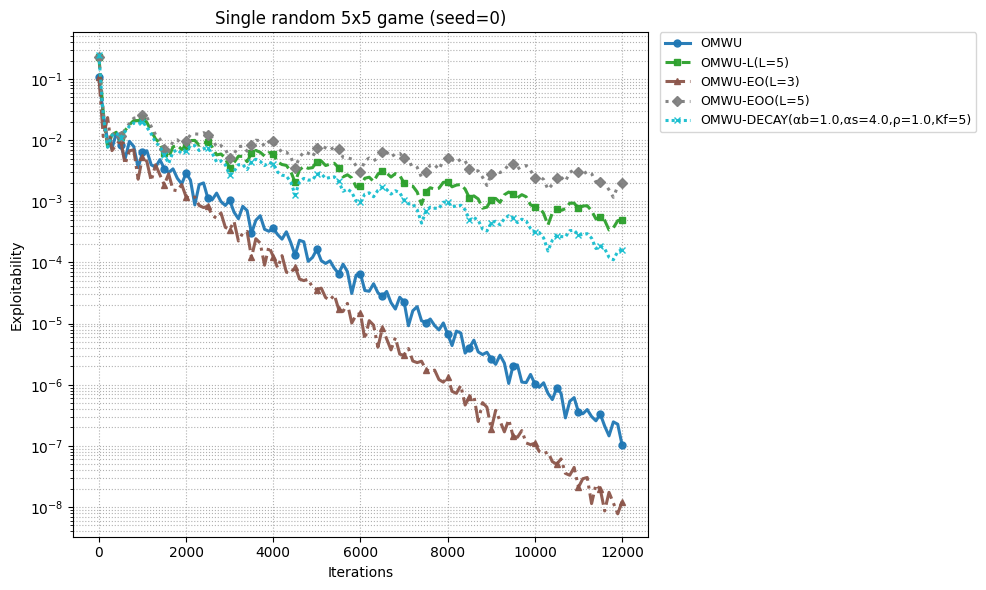

In [95]:
#!/usr/bin/env python3
"""
Single run on one random 5x5 zero-sum game:
  - Variants: OMWU, OMWU-L, OMWU-EO, OMWU-EOO, OMWU-DECAY
  - Independent hyperparameters per variant (eta, L, alpha_b, alpha_s, rho, Kf)
  - Progress printing + one plot at the end
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple

# ========================= USER CONFIG (edit me) =========================

@dataclass
class Config:
    T: int = 12000               # iterations
    print_every: int = 500       # console progress
    plot_every: int = 100        # sampling for curves
    seed: int = 0                # RNG seed for the single random game
    dtype: str = "float64"       # "float64" or "longdouble"
    n: int = 5                   # game size (n x n)
    random_scale: float = 1.0    # std-dev for random payoff entries

CFG = Config()

# Per-variant independent hyperparameters
VARIANT_CFG = {
    "OMWU":        {"eta": 1.0}, # 1.05 breaks this
    # "OMWU-EO":     {"eta": 0.67, "L": 2}, # BEST 1.3333
    "OMWU-EO":     {"eta": 0.50, "L": 3},   # BEST 1.5
    # "OMWU-EO":     {"eta": 0.1, "L": 10},   #
    "OMWU-EOO":    {"eta": 0.10, "L": 5},
    "OMWU-L":      {"eta": 0.10, "L": 5},
    "OMWU-DECAY":  {"eta": 0.10, "alpha_b": 1.0, "alpha_s": 4.0, "rho": 1.0, "Kf": 5},
}

# ========================================================================

# ============================ numerics helpers ===========================

def get_dtype(name: str):
    if name == "float64":
        return np.float64
    elif name == "longdouble":
        return np.longdouble
    raise ValueError("dtype must be 'float64' or 'longdouble'")

def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    return e / np.sum(e)

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)
    exploit = 0.5 * nconv
    return nconv, exploit

def sampling_times(T: int, plot_every: int) -> List[int]:
    return [1] + list(range(plot_every, T + 1, plot_every))

# ================================ agents =================================

class AgentBase:
    def __init__(self, n: int, eta: float, label: str, DTYPE):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.DTYPE = DTYPE
        self.b = np.zeros(n, dtype=DTYPE)
        self.x = softmax(self.b)
        self.g_prev = np.zeros(n, dtype=DTYPE)
        self.t = 0
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_g(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, idx_from_1: int) -> np.ndarray:
        if idx_from_1 <= 0 or idx_from_1 > len(self._g_hist):
            return np.zeros(self.n, dtype=self.DTYPE)
        return self._g_hist[idx_from_1 - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError

# ------------------------------ OMWU --------------------------------------

class OMWU(AgentBase):
    def __init__(self, n: int, eta: float, DTYPE):
        super().__init__(n, eta, "OMWU", DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-L ------------------------------------

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-L(L={L})", DTYPE)
        self.L = int(L)
        self._histL: List[np.ndarray] = []
        self._sumL = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.DTYPE(self.L) + 1.0) * g_t - self._sumL
        d_t = base
        # update window after using it
        self._histL.insert(0, g_t.copy()); self._sumL += g_t
        if len(self._histL) > self.L:
            old = self._histL.pop(); self._sumL -= old
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EO -----------------------------------

class OMWU_EO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EO(L={L})", DTYPE)
        self.L = int(L)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - (self.DTYPE(self.L) * self.g_prev)
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EOO ----------------------------------

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EOO(L={L})", DTYPE)
        self.L = int(L)
        self.pending = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_g(g_t)

# ------------------------------ OMWU-DECAY --------------------------------

class OMWU_DECAY(AgentBase):
    """
    d_t = α_b g_t − (α_b−1) g_{t−1} + sum_{j=0}^{Kf−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
    g_{t-k} := 0 if missing.
    """
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int, DTYPE):
        label = f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})"
        super().__init__(n, eta, label, DTYPE)
        self.alpha_b = DTYPE(alpha_b)
        self.alpha_s = DTYPE(alpha_s)
        self.rho = DTYPE(rho)
        self.Kf = int(Kf)

    def _finite_diff_tail(self, g_t: np.ndarray) -> np.ndarray:
        if self.Kf <= 0:
            return np.zeros_like(g_t)
        tail = np.zeros_like(g_t)
        zeros = np.zeros_like(g_t)
        for j in range(self.Kf):
            g_tj  = g_t if j == 0 else (self._get_g(self.t - j) if (self.t - j) >= 1 else zeros)
            g_tjm1 = self._get_g(self.t - j - 1) if (self.t - j - 1) >= 1 else zeros
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tjm1)
        return tail

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = self._finite_diff_tail(g_t)
        d_t = base + tail
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ============================== game maker ================================

def make_random_zero_sum(n: int, scale: float, rng: np.random.Generator) -> np.ndarray:
    """
    Single random zero-sum game for the row player:
      Row payoff = A; Column payoff = -A.
    """
    A = rng.normal(0.0, scale, size=(n, n))
    return A

# ============================ experiment core =============================

def run_one_game(A: np.ndarray, T: int, plot_every: int, print_every: int,
                 agents: Dict[str, Tuple[AgentBase, AgentBase]]):
    records = {lbl: {"times": [], "exploit": []} for lbl in agents}

    for t in range(1, T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy()
            y = col.next_strategy()
            g_row = row_grad(A, y)
            g_col = col_grad(A, x)
            row.observe_gradient(g_row)
            col.observe_gradient(g_col)

        if t == 1 or (t % plot_every) == 0:
            for lbl, (row, col) in agents.items():
                x2 = row.next_strategy(); y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t)
                records[lbl]["exploit"].append(ex)

        if t == 1 or (t % print_every) == 0:
            msg = [f"t={t:6d}"]
            for lbl in agents:
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # Length alignment (safety)
    t_ref = None
    for lbl in records:
        if t_ref is None:
            t_ref = len(records[lbl]["times"])
        else:
            m = min(t_ref, len(records[lbl]["times"]), len(records[lbl]["exploit"]))
            records[lbl]["times"] = records[lbl]["times"][:m]
            records[lbl]["exploit"] = records[lbl]["exploit"][:m]

    return records

# =============================== plotting =================================

def make_style_map(labels: List[str]):
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab10', len(labels))
    linestyles = ['-', '--', '-.', ':', (0, (1, 1))]
    markers = ['o', 's', '^', 'D', 'x']
    style_map = {}
    for i, lbl in enumerate(labels):
        style_map[lbl] = dict(color=cmap(i), linestyle=linestyles[i % len(linestyles)],
                              linewidth=2.2, alpha=0.95, marker=markers[i % len(markers)],
                              markevery=5, markersize=5)
    return style_map

def plot_single(records, title: str):
    labels = list(records.keys())
    style_map = make_style_map(labels)

    plt.figure(figsize=(10, 6))
    for lbl in labels:
        xs = np.array(records[lbl]["times"], dtype=float)
        ys = np.array(records[lbl]["exploit"], dtype=float)
        plt.plot(xs, ys, label=lbl, **style_map[lbl])
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel("Exploitability")
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    plt.legend(fontsize=9, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# ================================= main ===================================

def make_agents(n: int, DTYPE, cfg: Dict[str, Dict]) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}

    # OMWU
    p = cfg["OMWU"]
    agents["OMWU"] = (OMWU(n, p["eta"], DTYPE), OMWU(n, p["eta"], DTYPE))

    # OMWU-L
    p = cfg["OMWU-L"]
    agents[f"OMWU-L(L={p['L']})"] = (OMWU_L(n, p["eta"], p["L"], DTYPE), OMWU_L(n, p["eta"], p["L"], DTYPE))

    # OMWU-EO
    p = cfg["OMWU-EO"]
    agents[f"OMWU-EO(L={p['L']})"] = (OMWU_EO(n, p["eta"], p["L"], DTYPE), OMWU_EO(n, p["eta"], p["L"], DTYPE))

    # OMWU-EOO
    p = cfg["OMWU-EOO"]
    agents[f"OMWU-EOO(L={p['L']})"] = (OMWU_EOO(n, p["eta"], p["L"], DTYPE), OMWU_EOO(n, p["eta"], p["L"], DTYPE))

    # OMWU-DECAY
    p = cfg["OMWU-DECAY"]
    lab = f"OMWU-DECAY(αb={p['alpha_b']},αs={p['alpha_s']},ρ={p['rho']},Kf={p['Kf']})"
    agents[lab] = (
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
    )
    return agents

def main():
    print("Config:", asdict(CFG))
    print("Variant hyperparameters:", VARIANT_CFG)
    DTYPE = get_dtype(CFG.dtype)
    rng = np.random.default_rng(CFG.seed)

    # Build one random game (row payoff A, col payoff -A)
    A = make_random_zero_sum(CFG.n, CFG.random_scale, rng)
    print(f"[info] Single random game generated  |  seed={CFG.seed}  |  shape={A.shape}")

    # Build agents (per-variant hyperparameters)
    agents = make_agents(CFG.n, DTYPE, VARIANT_CFG)

    # Run
    records = run_one_game(A, CFG.T, CFG.plot_every, CFG.print_every, agents)

    # Plot
    plot_single(records, title=f"Single random {CFG.n}x{CFG.n} game (seed={CFG.seed})")

if __name__ == "__main__":
    main()


In [96]:
#########################################
###########################################

Config: {'T': 20000, 'print_every': 500, 'plot_every': 10, 'seed': 53, 'dtype': 'float64', 'n': 8, 'random_scale': 1.0}
Variant hyperparameters: {'OMWU': {'eta': 1.0}, 'OMWU-L': {'eta': 0.51, 'L': 2}, 'OMWU-EO': {'eta': 0.67, 'alpha': 2.0}, 'OMWU-EOO': {'eta': 0.34, 'L': 3}, 'OMWU-DECAY': {'eta': 0.5, 'alpha_b': 1.0, 'alpha_s': 2.0, 'rho': 0.5, 'Kf': 2}}
[info] Single random game generated  |  seed=53  |  shape=(8, 8)
[progress] t=     1  OMWU: ex=3.654e-01  OMWU-L(L=2): ex=3.880e-01  OMWU-EO(α=2.0): ex=3.650e-01  OMWU-EOO(L=3): ex=3.979e-01  OMWU-DECAY(αb=1.0,αs=2.0,ρ=0.5,Kf=2): ex=3.897e-01
[progress] t=   500  OMWU: ex=8.198e-02  OMWU-L(L=2): ex=1.272e-01  OMWU-EO(α=2.0): ex=6.816e-02  OMWU-EOO(L=3): ex=1.602e-01  OMWU-DECAY(αb=1.0,αs=2.0,ρ=0.5,Kf=2): ex=1.028e-01
[progress] t=  1000  OMWU: ex=7.766e-02  OMWU-L(L=2): ex=1.621e-01  OMWU-EO(α=2.0): ex=8.853e-02  OMWU-EOO(L=3): ex=1.545e-01  OMWU-DECAY(αb=1.0,αs=2.0,ρ=0.5,Kf=2): ex=1.015e-01
[progress] t=  1500  OMWU: ex=5.968e-02  OMW

/tmp/ipython-input-2667240662.py:288: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(labels))


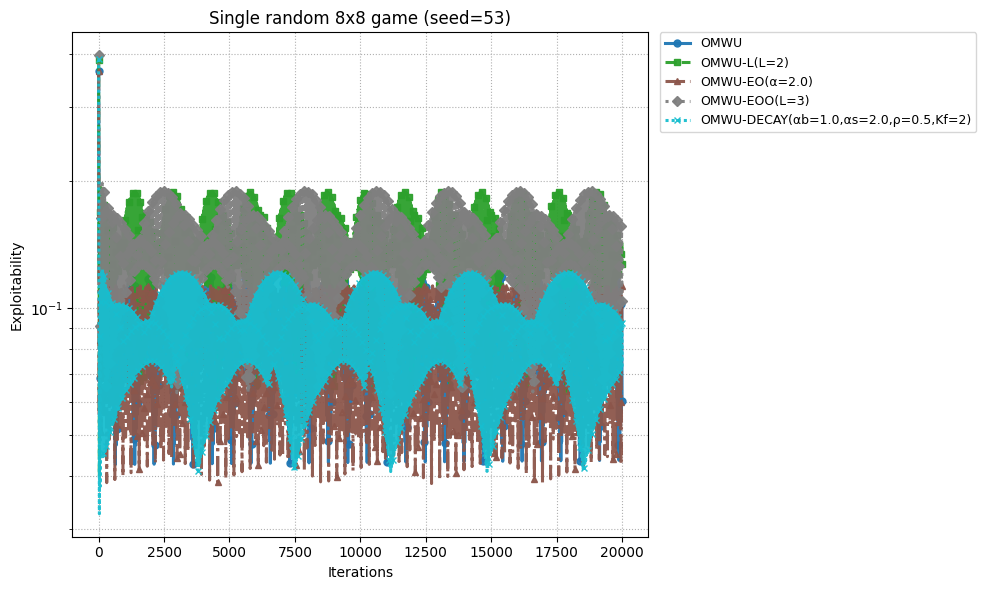

In [14]:
#!/usr/bin/env python3
"""
Single run on one random 5x5 zero-sum game:
  - Variants: OMWU, OMWU-L, OMWU-EO (now with fractional alpha), OMWU-EOO, OMWU-DECAY
  - Independent hyperparameters per variant (eta, L/alpha, alpha_b, alpha_s, rho, Kf)
  - Progress printing + one plot at the end
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple

# ========================= USER CONFIG (edit me) =========================

# "OMWU-EO":     {"eta": 0.67, "L": 2}, # BEST 1.3333
    # "OMWU-EO":     {"eta": 0.50, "L": 3},   # BEST 1.5

@dataclass
class Config:
    T: int = 20000               # iterations
    print_every: int = 500       # console progress
    plot_every: int = 10        # sampling for curves
    seed: int = 53               # RNG seed for the single random game
    dtype: str = "float64"       # "float64" or "longdouble"
    n: int = 8                   # game size (n x n)
    random_scale: float = 1.0    # std-dev for random payoff entries

CFG = Config()

# Per-variant independent hyperparameters
# NOTE: OMWU-EO now supports fractional alpha via key "alpha".
#       If "alpha" is absent but "L" is present, we use alpha=float(L) for backward-compat.

# "OMWU-EO":     {"eta": 0.67, "L": 2}, # BEST 1.3333
# "OMWU-EO":     {"eta": 0.50, "L": 3},   # BEST 1.5
VARIANT_CFG = {
    "OMWU":        {"eta": 1.0},
    "OMWU-L":      {"eta": 0.51, "L": 2},
    # Examples for EO alpha:
    #   alpha=0.5 -> 1.5*g_t - 0.5*g_{t-1}
    #   alpha=1.2 -> 2.2*g_t - 1.2*g_{t-1}
    "OMWU-EO":     {"eta": 0.67, "alpha": 2.0}, # BEST
    # "OMWU-EOO":    {"eta": 0.51, "L": 2},
    "OMWU-EOO":    {"eta": 0.34, "L": 3},
    "OMWU-DECAY":  {"eta": 0.50, "alpha_b": 1.0, "alpha_s": 2.0, "rho": 0.5, "Kf": 2},
}

# ========================================================================

# ============================ numerics helpers ===========================

def get_dtype(name: str):
    if name == "float64":
        return np.float64
    elif name == "longdouble":
        return np.longdouble
    raise ValueError("dtype must be 'float64' or 'longdouble'")

def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    return e / np.sum(e)

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)
    exploit = 0.5 * nconv
    return nconv, exploit

def sampling_times(T: int, plot_every: int) -> List[int]:
    return [1] + list(range(plot_every, T + 1, plot_every))

# ================================ agents =================================

class AgentBase:
    def __init__(self, n: int, eta: float, label: str, DTYPE):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.DTYPE = DTYPE
        self.b = np.zeros(n, dtype=DTYPE)
        self.x = softmax(self.b)
        self.g_prev = np.zeros(n, dtype=DTYPE)
        self.t = 0
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_g(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, idx_from_1: int) -> np.ndarray:
        if idx_from_1 <= 0 or idx_from_1 > len(self._g_hist):
            return np.zeros(self.n, dtype=self.DTYPE)
        return self._g_hist[idx_from_1 - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError

# ------------------------------ OMWU --------------------------------------

class OMWU(AgentBase):
    def __init__(self, n: int, eta: float, DTYPE):
        super().__init__(n, eta, "OMWU", DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-L ------------------------------------

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-L(L={L})", DTYPE)
        self.L = int(L)
        self._histL: List[np.ndarray] = []
        self._sumL = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.DTYPE(self.L) + 1.0) * g_t - self._sumL
        d_t = base
        # update window after using it
        self._histL.insert(0, g_t.copy()); self._sumL += g_t
        if len(self._histL) > self.L:
            old = self._histL.pop(); self._sumL -= old
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EO (fractional alpha) ----------------

class OMWU_EO(AgentBase):
    """
    EO with fractional alpha:
      d_t = (1 + alpha) * g_t - alpha * g_{t-1}
           = 1 * g_t + alpha * (g_t - g_{t-1})
    If 'alpha' not provided, but 'L' is, uses alpha = float(L) (backward compatible).
    """
    def __init__(self, n: int, eta: float, alpha: float | None = None, L: int | None = None, DTYPE=None):
        # Resolve alpha (fractional allowed). If only L given, alpha = float(L).
        if alpha is None and L is None:
            raise ValueError("OMWU_EO requires 'alpha' (float) or 'L' (int/float).")
        if alpha is None:
            alpha = float(L)
        self.alpha = float(alpha)
        label = f"OMWU-EO(α={self.alpha})" if (alpha is not None) else f"OMWU-EO(L={L})"
        super().__init__(n, eta, label, DTYPE)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        a = self.DTYPE(self.alpha)
        d_t = (a + 1.0) * g_t - a * self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EOO ----------------------------------

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EOO(L={L})", DTYPE)
        self.L = int(L)
        self.pending = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_g(g_t)

# ------------------------------ OMWU-DECAY --------------------------------

class OMWU_DECAY(AgentBase):
    """
    d_t = α_b g_t − (α_b−1) g_{t−1} + sum_{j=0}^{Kf−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
    g_{t-k} := 0 if missing.
    """
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int, DTYPE):
        label = f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})"
        super().__init__(n, eta, label, DTYPE)
        self.alpha_b = DTYPE(alpha_b)
        self.alpha_s = DTYPE(alpha_s)
        self.rho = DTYPE(rho)
        self.Kf = int(Kf)

    def _finite_diff_tail(self, g_t: np.ndarray) -> np.ndarray:
        if self.Kf <= 0:
            return np.zeros_like(g_t)
        tail = np.zeros_like(g_t)
        zeros = np.zeros_like(g_t)
        for j in range(self.Kf):
            g_tj  = g_t if j == 0 else (self._get_g(self.t - j) if (self.t - j) >= 1 else zeros)
            g_tjm1 = self._get_g(self.t - j - 1) if (self.t - j - 1) >= 1 else zeros
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tjm1)
        return tail

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = self._finite_diff_tail(g_t)
        d_t = base + tail
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ============================== game maker ================================

def make_random_zero_sum(n: int, scale: float, rng: np.random.Generator) -> np.ndarray:
    """
    Single random zero-sum game for the row player:
      Row payoff = A; Column payoff = -A.
    """
    # A = rng.random(size=(n, n)) * scale # Changed from rng.normal
    A = rng.normal(0.0, scale, size=(n, n))
    return A

# ============================ experiment core =============================

def run_one_game(A: np.ndarray, T: int, plot_every: int, print_every: int,
                 agents: Dict[str, Tuple[AgentBase, AgentBase]]):
    records = {lbl: {"times": [], "exploit": []} for lbl in agents}

    for t in range(1, T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy()
            y = col.next_strategy()
            g_row = row_grad(A, y)
            g_col = col_grad(A, x)
            row.observe_gradient(g_row)
            col.observe_gradient(g_col)

        if t == 1 or (t % plot_every) == 0:
            for lbl, (row, col) in agents.items():
                x2 = row.next_strategy(); y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t)
                records[lbl]["exploit"].append(ex)

        if t == 1 or (t % print_every) == 0:
            msg = [f"t={t:6d}"]
            for lbl in agents:
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # Length alignment (safety)
    t_ref = None
    for lbl in records:
        if t_ref is None:
            t_ref = len(records[lbl]["times"])
        else:
            m = min(t_ref, len(records[lbl]["times"]), len(records[lbl]["exploit"]))
            records[lbl]["times"] = records[lbl]["times"][:m]
            records[lbl]["exploit"] = records[lbl]["exploit"][:m]

    return records

# =============================== plotting =================================

def make_style_map(labels: List[str]):
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab10', len(labels))
    linestyles = ['-', '--', '-.', ':', (0, (1, 1))]
    markers = ['o', 's', '^', 'D', 'x']
    style_map = {}
    for i, lbl in enumerate(labels):
        style_map[lbl] = dict(color=cmap(i), linestyle=linestyles[i % len(linestyles)],
                              linewidth=2.2, alpha=0.95, marker=markers[i % len(markers)],
                              markevery=5, markersize=5)
    return style_map

def plot_single(records, title: str):
    labels = list(records.keys())
    style_map = make_style_map(labels)

    plt.figure(figsize=(10, 6))
    for lbl in labels:
        xs = np.array(records[lbl]["times"], dtype=float)
        ys = np.array(records[lbl]["exploit"], dtype=float)
        plt.plot(xs, ys, label=lbl, **style_map[lbl])
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel("Exploitability")
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    plt.legend(fontsize=9, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# ================================= main ===================================

def make_agents(n: int, DTYPE, cfg: Dict[str, Dict]) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}

    # OMWU
    p = cfg["OMWU"]
    agents["OMWU"] = (OMWU(n, p["eta"], DTYPE), OMWU(n, p["eta"], DTYPE))

    # OMWU-L
    p = cfg["OMWU-L"]
    agents[f"OMWU-L(L={p['L']})"] = (OMWU_L(n, p["eta"], p["L"], DTYPE), OMWU_L(n, p["eta"], p["L"], DTYPE))

    # OMWU-EO (fractional alpha)
    p = cfg["OMWU-EO"]
    # Determine alpha (prefer p['alpha'] if present; else use float(L))
    alpha = float(p["alpha"]) if ("alpha" in p) else float(p["L"])
    eo_label = f"OMWU-EO(α={alpha})"
    agents[eo_label] = (OMWU_EO(n, p["eta"], alpha=alpha, DTYPE=DTYPE),
                        OMWU_EO(n, p["eta"], alpha=alpha, DTYPE=DTYPE))

    # OMWU-EOO
    p = cfg["OMWU-EOO"]
    agents[f"OMWU-EOO(L={p['L']})"] = (OMWU_EOO(n, p["eta"], p["L"], DTYPE), OMWU_EOO(n, p["eta"], p["L"], DTYPE))

    # OMWU-DECAY
    p = cfg["OMWU-DECAY"]
    lab = f"OMWU-DECAY(αb={p['alpha_b']},αs={p['alpha_s']},ρ={p['rho']},Kf={p['Kf']})"
    agents[lab] = (
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
    )
    return agents

def main():
    print("Config:", asdict(CFG))
    print("Variant hyperparameters:", VARIANT_CFG)
    DTYPE = get_dtype(CFG.dtype)
    rng = np.random.default_rng(CFG.seed)

    # Build one random game (row payoff A, col payoff -A)
    A = make_random_zero_sum(CFG.n, CFG.random_scale, rng)
    print(f"[info] Single random game generated  |  seed={CFG.seed}  |  shape={A.shape}")

    # Build agents (per-variant hyperparameters)
    agents = make_agents(CFG.n, DTYPE, VARIANT_CFG)

    # Run
    records = run_one_game(A, CFG.T, CFG.plot_every, CFG.print_every, agents)

    # Plot
    plot_single(records, title=f"Single random {CFG.n}x{CFG.n} game (seed={CFG.seed})")

if __name__ == "__main__":
    main()

In [15]:
#####################################
########################################

Config: {'T': 32500, 'print_every': 500, 'plot_every': 100, 'seed': 10131, 'dtype': 'float64', 'n': 25, 'random_scale': 1.0, 'game_type': 'random_skew'}
Variant hyperparameters: {'OMWU': {'eta': 1.0}, 'OMWU-L': {'eta': 0.5, 'L': 4}, 'OMWU-EO': {'eta': 0.65, 'L': 2}, 'OMWU-EOO': {'eta': 0.5, 'L': 2}, 'OMWU-DECAY': {'eta': 0.1, 'alpha_b': 1.0, 'alpha_s': 5.0, 'rho': 1.0, 'Kf': 5}}
[info] Single random_skew game  |  seed=10131  |  shape=(25, 25)
[progress] t=     1  OMWU: ex=5.338e-02  OMWU-L(L=4): ex=5.227e-02  OMWU-EO(L=2): ex=5.349e-02  OMWU-EOO(L=2): ex=5.453e-02  OMWU-DECAY(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=5.673e-02
[progress] t=   500  OMWU: ex=3.270e-02  OMWU-L(L=4): ex=1.435e-02  OMWU-EO(L=2): ex=1.872e-02  OMWU-EOO(L=2): ex=1.785e-02  OMWU-DECAY(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=2.633e-02
[progress] t=  1000  OMWU: ex=3.358e-02  OMWU-L(L=4): ex=1.566e-02  OMWU-EO(L=2): ex=1.927e-02  OMWU-EOO(L=2): ex=2.191e-02  OMWU-DECAY(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=1.068e-02
[progress] t=  1500  OMWU

/tmp/ipython-input-3590873400.py:332: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(labels))


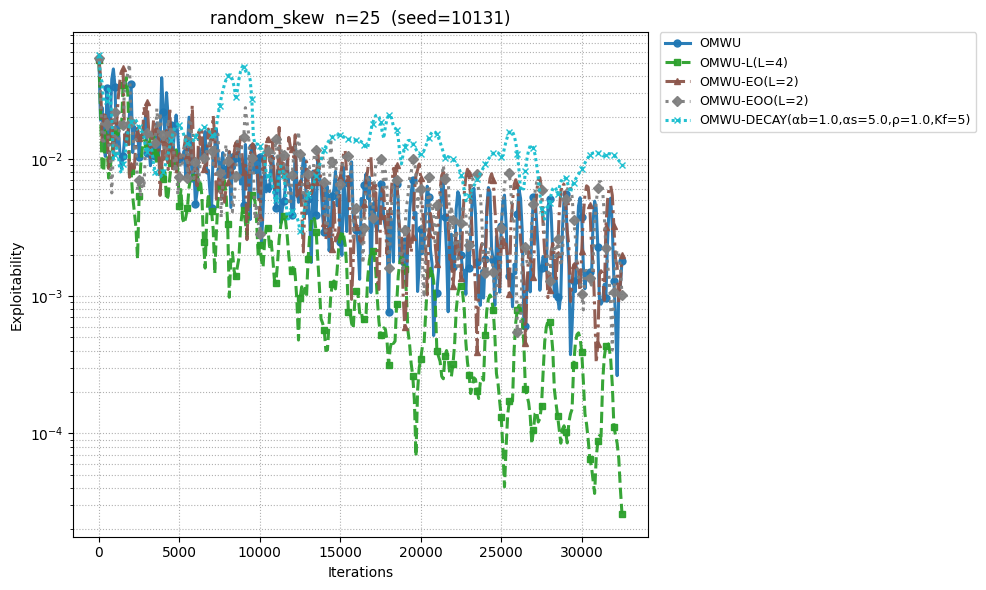

In [44]:
#!/usr/bin/env python3
"""
Single run on one random n×n zero-sum game:
  - Variants: OMWU, OMWU-L, OMWU-EO (integer L), OMWU-EOO, OMWU-DECAY
  - Independent hyperparameters per variant (eta, L, alpha_b, alpha_s, rho, Kf)
  - Progress printing + one plot at the end
  - Multiple random game generators selectable via CFG.game_type

Game types (medium→hard):
  - "random_skew"        : A = (M - M^T)/2 (purely antisymmetric)
  - "lowrank_skew"       : antisymmetric low-rank core + small noise
  - "cyclic_perturbed"   : cyclic band antisymmetric + noise
  - "block_antisym"      : 2-block directed structure, antisymmetrized
  - "illcond_skew"       : antisymmetric with ill-conditioned row/col scaling
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple

# ========================= USER CONFIG (edit me) =========================

@dataclass
class Config:
    T: int = 32500               # iterations
    print_every: int = 500       # console progress
    plot_every: int = 100        # sampling for curves
    seed: int = 10131                # RNG seed for the single random game
    dtype: str = "float64"       # "float64" or "longdouble"
    n: int = 25                   # game size (n x n)
    random_scale: float = 1.0    # std-dev for random entries (base scale)
    game_type: str = "random_skew"  # choose from the list in the module docstring

CFG = Config()

# Per-variant independent hyperparameters
# NOTE: EO is back to integer L: d_t = (L+1)g_t - L g_{t-1}
VARIANT_CFG = {
    "OMWU":        {"eta": 1.0},
    "OMWU-L":      {"eta": 0.5, "L": 4},
    "OMWU-EO":     {"eta": 0.65, "L": 2},    # integer L optimism (round number)
    "OMWU-EOO":    {"eta": 0.5, "L": 2},
    "OMWU-DECAY":  {"eta": 0.10, "alpha_b": 1.0, "alpha_s": 5.0, "rho": 1.0, "Kf": 5},
}

# ========================================================================

# ============================ numerics helpers ===========================

def get_dtype(name: str):
    if name == "float64":
        return np.float64
    elif name == "longdouble":
        return np.longdouble
    raise ValueError("dtype must be 'float64' or 'longdouble'")

def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    return e / np.sum(e)

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)
    exploit = 0.5 * nconv
    return nconv, exploit

def sampling_times(T: int, plot_every: int) -> List[int]:
    return [1] + list(range(plot_every, T + 1, plot_every))

# ================================ agents =================================

class AgentBase:
    def __init__(self, n: int, eta: float, label: str, DTYPE):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.DTYPE = DTYPE
        self.b = np.zeros(n, dtype=DTYPE)
        self.x = softmax(self.b)
        self.g_prev = np.zeros(n, dtype=DTYPE)
        self.t = 0
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_g(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, idx_from_1: int) -> np.ndarray:
        if idx_from_1 <= 0 or idx_from_1 > len(self._g_hist):
            return np.zeros(self.n, dtype=self.DTYPE)
        return self._g_hist[idx_from_1 - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError

# ------------------------------ OMWU --------------------------------------

class OMWU(AgentBase):
    def __init__(self, n: int, eta: float, DTYPE):
        super().__init__(n, eta, "OMWU", DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-L ------------------------------------

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-L(L={L})", DTYPE)
        self.L = int(L)
        self._histL: List[np.ndarray] = []
        self._sumL = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.DTYPE(self.L) + 1.0) * g_t - self._sumL
        d_t = base
        # update window after using it
        self._histL.insert(0, g_t.copy()); self._sumL += g_t
        if len(self._histL) > self.L:
            old = self._histL.pop(); self._sumL -= old
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EO (integer L) -----------------------

class OMWU_EO(AgentBase):
    """
    EO with *integer* breadth L:
      d_t = (L + 1) * g_t - L * g_{t-1}
    """
    def __init__(self, n: int, eta: float, L: int, DTYPE=None):
        self.L = int(L)
        super().__init__(n, eta, f"OMWU-EO(L={self.L})", DTYPE)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        L = self.DTYPE(self.L)
        d_t = (L + 1.0) * g_t - L * self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EOO ----------------------------------

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EOO(L={L})", DTYPE)
        self.L = int(L)
        self.pending = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_g(g_t)

# ------------------------------ OMWU-DECAY --------------------------------

class OMWU_DECAY(AgentBase):
    """
    d_t = α_b g_t − (α_b−1) g_{t−1} + sum_{j=0}^{Kf−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
    g_{t-k} := 0 if missing.
    """
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int, DTYPE):
        label = f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})"
        super().__init__(n, eta, label, DTYPE)
        self.alpha_b = DTYPE(alpha_b)
        self.alpha_s = DTYPE(alpha_s)
        self.rho = DTYPE(rho)
        self.Kf = int(Kf)

    def _finite_diff_tail(self, g_t: np.ndarray) -> np.ndarray:
        if self.Kf <= 0:
            return np.zeros_like(g_t)
        tail = np.zeros_like(g_t)
        zeros = np.zeros_like(g_t)
        for j in range(self.Kf):
            g_tj  = g_t if j == 0 else (self._get_g(self.t - j) if (self.t - j) >= 1 else zeros)
            g_tjm1 = self._get_g(self.t - j - 1) if (self.t - j - 1) >= 1 else zeros
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tjm1)
        return tail

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = self._finite_diff_tail(g_t)
        d_t = base + tail
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ============================== game makers ===============================

def make_random_skew(n: int, scale: float, rng: np.random.Generator) -> np.ndarray:
    """Pure antisymmetric: A = (M - M^T)/2."""
    M = rng.normal(0.0, scale, size=(n, n))
    return 2.2*(M - M.T) / 12.0

def make_lowrank_skew(n: int, rank: int, noise_scale: float, rng: np.random.Generator) -> np.ndarray:
    """Low-rank antisymmetric core + small noise."""
    U = rng.normal(0.0, 1.0, size=(n, rank))
    V = rng.normal(0.0, 1.0, size=(n, rank))
    core = U @ V.T
    A = (core - core.T) / 12.0
    A += rng.normal(0.0, noise_scale, size=(n, n)) * 0.212  # gentle noise
    A = (A - A.T) / 1.0
    return A

def make_cyclic_perturbed(n: int, base_strength: float, noise_scale: float, rng: np.random.Generator) -> np.ndarray:
    """Cyclic band antisymmetric with random perturbations."""
    A = np.zeros((n, n))
    for i in range(n):
        A[i, (i+1) % n] = base_strength
        A[(i+1) % n, i] = -base_strength
    A += rng.normal(0.0, noise_scale, size=(n, n))
    A = (A - A.T) / 2.0
    return A

def make_block_antisym(n: int, strength: float, noise_scale: float, rng: np.random.Generator) -> np.ndarray:
    """Two-block directed structure, then antisymmetrize."""
    if n < 4:
        raise ValueError("block_antisym requires n >= 4")
    A = rng.normal(0.0, noise_scale, size=(n, n))
    mid = n // 2
    # push block 0 -> block 1 positively, reverse negative
    A[:mid, mid:] += strength
    A[mid:, :mid] -= strength
    A = (A - A.T) / 2.0
    return A

def make_illcond_skew(n: int, scale: float, cond: float, rng: np.random.Generator) -> np.ndarray:
    """Antisymmetric with ill-conditioned scaling: A' = S A S, diag(S) logspaced."""
    M = rng.normal(0.0, scale, size=(n, n))
    A = (M - M.T) / 2.0
    svals = np.logspace(0.0, np.log10(cond), num=n)  # from 1 to cond
    S = np.diag(svals)
    A = S @ A @ S
    A = (A - A.T) / 2.0
    return A

def gen_game(game_type: str, n: int, rng: np.random.Generator, base_scale: float) -> np.ndarray:
    gt = game_type.lower()
    if gt == "random_skew":
        return make_random_skew(n, base_scale, rng)
    elif gt == "lowrank_skew":
        return make_lowrank_skew(n, rank=max(2, n//3), noise_scale=base_scale, rng=rng)
    elif gt == "cyclic_perturbed":
        return make_cyclic_perturbed(n, base_strength=1.0, noise_scale=0.5 * base_scale, rng=rng)
    elif gt == "block_antisym":
        return make_block_antisym(n, strength=1.0, noise_scale=0.25 * base_scale, rng=rng)
    elif gt == "illcond_skew":
        return make_illcond_skew(n, scale=base_scale, cond=20.0, rng=rng)
    else:
        raise ValueError(f"Unknown game_type '{game_type}'. "
                         f"Choose one of: random_skew, lowrank_skew, cyclic_perturbed, block_antisym, illcond_skew")

# ============================ experiment core =============================

def run_one_game(A: np.ndarray, T: int, plot_every: int, print_every: int,
                 agents: Dict[str, Tuple[AgentBase, AgentBase]]):
    records = {lbl: {"times": [], "exploit": []} for lbl in agents}

    for t in range(1, T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy()
            y = col.next_strategy()
            g_row = row_grad(A, y)
            g_col = col_grad(A, x)
            row.observe_gradient(g_row)
            col.observe_gradient(g_col)

        if t == 1 or (t % plot_every) == 0:
            for lbl, (row, col) in agents.items():
                x2 = row.next_strategy(); y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t)
                records[lbl]["exploit"].append(ex)

        if t == 1 or (t % print_every) == 0:
            msg = [f"t={t:6d}"]
            for lbl in agents:
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # Length alignment (safety)
    t_ref = None
    for lbl in records:
        if t_ref is None:
            t_ref = len(records[lbl]["times"])
        else:
            m = min(t_ref, len(records[lbl]["times"]), len(records[lbl]["exploit"]))
            records[lbl]["times"] = records[lbl]["times"][:m]
            records[lbl]["exploit"] = records[lbl]["exploit"][:m]

    return records

# =============================== plotting =================================

def make_style_map(labels: List[str]):
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab10', len(labels))
    linestyles = ['-', '--', '-.', ':', (0, (1, 1))]
    markers = ['o', 's', '^', 'D', 'x']
    style_map = {}
    for i, lbl in enumerate(labels):
        style_map[lbl] = dict(color=cmap(i), linestyle=linestyles[i % len(linestyles)],
                              linewidth=2.2, alpha=0.95, marker=markers[i % len(markers)],
                              markevery=5, markersize=5)
    return style_map

def plot_single(records, title: str):
    labels = list(records.keys())
    style_map = make_style_map(labels)

    plt.figure(figsize=(10, 6))
    for lbl in labels:
        xs = np.array(records[lbl]["times"], dtype=float)
        ys = np.array(records[lbl]["exploit"], dtype=float)
        plt.plot(xs, ys, label=lbl, **style_map[lbl])
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel("Exploitability")
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    plt.legend(fontsize=9, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# ================================= main ===================================

def make_agents(n: int, DTYPE, cfg: Dict[str, Dict]) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}

    # OMWU
    p = cfg["OMWU"]
    agents["OMWU"] = (OMWU(n, p["eta"], DTYPE), OMWU(n, p["eta"], DTYPE))

    # OMWU-L
    p = cfg["OMWU-L"]
    agents[f"OMWU-L(L={p['L']})"] = (OMWU_L(n, p["eta"], p["L"], DTYPE), OMWU_L(n, p["eta"], p["L"], DTYPE))

    # OMWU-EO (integer L)
    p = cfg["OMWU-EO"]
    agents[f"OMWU-EO(L={p['L']})"] = (OMWU_EO(n, p["eta"], p["L"], DTYPE), OMWU_EO(n, p["eta"], p["L"], DTYPE))

    # OMWU-EOO
    p = cfg["OMWU-EOO"]
    agents[f"OMWU-EOO(L={p['L']})"] = (OMWU_EOO(n, p["eta"], p["L"], DTYPE), OMWU_EOO(n, p["eta"], p["L"], DTYPE))

    # OMWU-DECAY
    p = cfg["OMWU-DECAY"]
    lab = f"OMWU-DECAY(αb={p['alpha_b']},αs={p['alpha_s']},ρ={p['rho']},Kf={p['Kf']})"
    agents[lab] = (
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
    )
    return agents

def main():
    print("Config:", asdict(CFG))
    print("Variant hyperparameters:", VARIANT_CFG)
    DTYPE = get_dtype(CFG.dtype)
    rng = np.random.default_rng(CFG.seed)

    # Build one random game of the chosen type (row payoff A, col payoff -A)
    A = gen_game(CFG.game_type, CFG.n, rng, CFG.random_scale)
    print(f"[info] Single {CFG.game_type} game  |  seed={CFG.seed}  |  shape={A.shape}")

    # Build agents (per-variant hyperparameters)
    agents = make_agents(CFG.n, DTYPE, VARIANT_CFG)

    # Run
    records = run_one_game(A, CFG.T, CFG.plot_every, CFG.print_every, agents)

    # Plot
    plot_single(records, title=f"{CFG.game_type}  n={CFG.n}  (seed={CFG.seed})")

if __name__ == "__main__":
    main()
